## **STAT 430 Final Project**

> *Author: Lucas Nelson*

> *Date: May 12, 2022*

Soccer analytics is a growing field that many professional clubs invest a great deal of resources into for the potential information gain that they can learn of themselves and their oponents. Such analyses have allowed teams to eliminate the influence of monetary differences on match outcomes and have given fans new insights into team and player performances that are not easily observed during matchtime. However, as soccer analytics continues to develop, increasingly more analyses have impacts that are not easily observable, such as player injury forecasting, team behaviour visualisation, talent discovery and transfer market evaluations (Barbosa et. al., 2021.), among others.

One such valuable piece of information teams can gather on any player is their playing style. Broadly speaking, playing style refers to a player's tendencies on the pitch, such as where they positions themselves on the pitch and which action(s) they tend to commit in said position. Offensive actions (eg. shot, dribble, pass, cross) are simple to measure since they are easily observed; however, not all defensive actions are simple to measure because their primary aim is to prevent an opponent's offensive action from occurring.

In this project, I aim to design player vectors that describe a player's offensive tendencies while in control of the ball. Using event stream data (provided by StatsBomb OpenAccess) of the 2003/2004 Premier League season, I map a player's offensive actions to uniformly distributed grids on a soccer pitch to generate a player's heatmap for a given on-ball action. I then apply Non-negative Matrix Factorization (NMF) on the heatmap to cluster the grids on the pitch as well as the Arsenal players to learn more about which specific actions occur on specific areas of the pitch as well as which players are committing said actions.

The following analysis includes a brief introduction to the dataset, including the differences between competitions as well as the challenges in working with event stream data. We then convert our match-by-match data into player-by-player heatmaps such that we can cluster our results for reasons stated above. Finally, we interpret our results and talk about the next steps for a similar analysis.

---

### **00. Imported Libraries**

---

In [1]:
# data processing libraries
import pandas as pd
import numpy as np

# clustering, dimension-reduction algorithms and performance metrics
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from pyclustertend import hopkins

# soccer open-access database provided by StatsBomb
from statsbombpy import sb

# various plotting and image filtering libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
from mplsoccer import Pitch, VerticalPitch
from scipy.ndimage import gaussian_filter

# filter non-useful warnings
from warnings import filterwarnings
from statsbombpy.api_client import NoAuthWarning
filterwarnings('ignore', category=NoAuthWarning)
filterwarnings('ignore', category=FutureWarning)

# functions designed for this project - see linked
# project repository to learn more about these
# project specific functions:
# https://github.com/lucas-nelson-uiuc/stat430_unsupervised_project
import project_data as projdata
import project_clustering as projclust
import project_plotting as projplot

---

### **01. About the Dataset**

---

Data for this project is provided by StatsBomb's OpenAccess platform. Within the dataset are a list of domestic, national, and international competitions for both male and female soccer clubs. These competitions range from regular season play within a country (e.g., Premier League (English), La Liga (Spanish)) to tournaments involving various countries (e.g., Champions League (European), Women's World Cup (international)), consisting of one or many matches depending on the format of the competition as well as - unfortunately - the amount of data provided by StatsBomb.

The table below breaks down the different ways a competition is categorized, including where the competition is held, which gender competes in it, the name of the competition, and which season the data is available for, as well as the number of matches available for said season.

In [2]:
# gather all competitions provided in OpenAccess
projdata.gather_sb_competitions()

num_matches
country_name             competition_gender competition_name        season_name             
England                  female             FA Women's Super League 2018/2019            108
                                                                    2019/2020             87
                                                                    2020/2021            131
                         male               Premier League          2003/2004             33
Europe                   male               Champions League        1999/2000              0
                                                                    2003/2004              1
                                                                    2004/2005              1
                                                                    2006/2007              1
                                                                    2008/2009              1
                                                                    2009/2010              1
                                                                    2010/2011              1
                                                                    2011/2012              1
                                                                    2012/2013              1
                                                                    2013/2014              1
                                                                    2014/2015              1
                                                                    2015/2016              1
                                                                    2016/2017              1
                                                                    2017/2018              1
                                                                    2018/2019              1
                                            UEFA Euro               2020                  51
International            female             Women's World Cup       2019                  52
                         male               FIFA World Cup          2018                  64
Spain                    male               La Liga                 2004/2005              7
                                                                    2005/2006             17
                                                                    2006/2007             26
                                                                    2007/2008             28
                                                                    2008/2009             31
                                                                    2009/2010             35
                                                                    2010/2011             33
                                                                    2011/2012             37
                                                                    2012/2013             32
                                                                    2013/2014             31
                                                                    2014/2015             38
                                                                    2015/2016             33
                                                                    2016/2017             34
                                                                    2017/2018             36
                                                                    2018/2019             34
                                                                    2019/2020             33
                                                                    2020/2021             35
United States of America female             NWSL                    2018                  36

For this project, we will be focusing on the single Premier League season, the 2003/2004 season where Arsenal famously earned themselves the nickname "The Invincibles" for finishing the season as undefeated champions. (Remember, soccer matches have three possible outcomes: win, draw, loss.) Even though we only have access to 33 of the 38 matches Arsenal competed in that season, we can still make a meaningful analysis out of The Invincibles's campaign.

---

### **02. Data Cleaning and Data Manipulation**

---

##### **i. Filtering Player-by-Player Stream Data**

Using the appropriate `competition_id` and `season_id` keys, let's access the dataframe we want. As we'll see, each row corresponds to a single match between Arsenal and another Premier League club. There is match specific information (when/where the match was played, names of each club's managers (coaches), etc.) as well as data specific information (date last updated, version for shot/tracking data, etc.). For a given `match_id`, we are provided an events matrix $X_{m \times n}$ comprised of $m$ events and $n$ attributes describing each event. For example, the events matrix of Arsenal's match against Middlesbrough (`match_id=3749358`) contains 3900 events, where each of the 89 columns (seen below) describe some detail about the event.

In [3]:
invincibles_df = sb.matches(competition_id=2, season_id=44).sort_values('match_date').reset_index(drop=True)
invincibles_df.head(3)

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated,last_updated_360,match_week,competition_stage,stadium,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3749493,2003-08-16,16:00:00.000,England - Premier League,2003/2004,Arsenal,Everton,2,1,available,...,2020-07-29T05:00,2021-06-13T16:17:31.694,1,Regular Season,Highbury Stadium,Arsène Wenger,David Moyes,1.1.0,2,2
1,3749358,2003-08-24,17:05:00.000,England - Premier League,2003/2004,Middlesbrough,Arsenal,0,4,available,...,2020-07-29T05:00,2021-06-13T16:17:31.694,1,Regular Season,Riverside Stadium,Steve McClaren,Arsène Wenger,1.1.0,2,2
2,3749454,2003-08-31,17:05:00.000,England - Premier League,2003/2004,Manchester City,Arsenal,1,2,available,...,2020-07-29T05:00,2021-06-13T16:17:31.694,1,Regular Season,Etihad Stadium,Kevin Joseph Keegan,Arsène Wenger,1.1.0,2,2


In [4]:
temp_df = sb.events(match_id=3749358)
print(f'Number of events     -> {temp_df.shape[0]}')
print(f'Number of attributes -> {temp_df.shape[1]}')
temp_df.columns

Number of events     -> 3900
Number of attributes -> 89


Index(['ball_receipt_outcome', 'ball_recovery_recovery_failure',
       'block_deflection', 'carry_end_location', 'clearance_aerial_won',
       'clearance_body_part', 'clearance_head', 'clearance_left_foot',
       'clearance_right_foot', 'counterpress', 'dribble_nutmeg',
       'dribble_outcome', 'dribble_overrun', 'duel_outcome', 'duel_type',
       'duration', 'foul_committed_advantage', 'foul_committed_card',
       'foul_committed_offensive', 'foul_committed_type', 'foul_won_advantage',
       'foul_won_defensive', 'goalkeeper_body_part', 'goalkeeper_end_location',
       'goalkeeper_outcome', 'goalkeeper_position', 'goalkeeper_punched_out',
       'goalkeeper_technique', 'goalkeeper_type', 'id', 'index',
       'interception_outcome', 'location', 'match_id', 'minute',
       'miscontrol_aerial_won', 'off_camera', 'out', 'pass_aerial_won',
       'pass_angle', 'pass_assisted_shot_id', 'pass_body_part', 'pass_cross',
       'pass_cut_back', 'pass_end_location', 'pass_goal_assist',

Looking at the list of all attributes provided, we see that some columns are more useful than others for the purpose of learning more about a player's playing style. For instance, attributes like `block_deflection` and `interception_outcome` represent defensive actions and other attributes like `tactics` and `timestamp` detail techincal information about the match, neither of which help us understand a player's offensive playing style. Let's loop over each `match_id` and gather the event stream dataframe for that match. Since we only want to design player vectors that contain offense-oriented events, we'll gather on-ball actions that involve a shot, pass, dribble, or cross as well as corresponding variables for each type (broadly speaking, when the action occurred, where on the pitch the action occurred, and the outcome of the action). This will all be stored in the `master_df` dataframe.

In [5]:
master_df = pd.concat([
    projdata.preprocessing_events_df(sb.events(match_id=idx))
    for idx in invincibles_df['match_id']
]).reset_index(drop=True)

# quick details about our master_df dataframe
print(f'Number of events     -> {master_df.shape[0]}')
print(f'Number of attributes -> {master_df.shape[1]}')

Number of events     -> 18714
Number of attributes -> 17


Wow. Over the 33 matches provided, there were 18,714 combined passes, shots, dribbles, and crosses. And people say soccer is boring ... I'm getting ahead of myself.

##### **ii. Creating Player Dictionaries**

Although we will not make use of the following datasets in this section until much later, we will still mention them here in the data section. To create our player vectors, we need to first separate out the actions by `player` to distinguish who did what and by `type` to learn more about how often (and - later on - which grid on the pitch) a player has committed an action. This will be saved in a dictionary for convenient data recollection later on.

In [7]:
# group master_df by player then by type
grouped_df = master_df.drop(columns='match_id').groupby(['player', 'type'])

# create dictionary of {player_name : {action_type: action_df}} for each player
player_dict = {player : dict() for player in master_df['player'].unique()}
for player_type, type_df in grouped_df:
    player_dict[player_type[0]][player_type[1]] = type_df

As a safety measure, here we ensure each player has a dataframe for every type, even if they haven't registered an event for said type (e.g., a goalkeeper is most likely not to have registered a shot). This is to avoid future errors in matrix operations due to differing shapes.

In [8]:
for player in player_dict:
    for action in ['Pass', 'Shot', 'Dribble', 'Cross']:
        if action not in player_dict[player].keys():
            # assign empty vector for player for corresponding action
            player_dict[player][action] = pd.DataFrame([player, action, np.nan, np.nan, np.nan, 0, 0, 0, 0, 0, 0, 0]).T

            # ensure dimensions and columns match existing dataframes
            player_dict[player][action].columns=['player', 'type', 'shot_outcome', 'dribble_outcome', 
                'pass_cross', 'shot_statsbomb_xg', 'minute', 'second',
                'location_x', 'location_y', 'pass_end_x', 'pass_end_y']

##### **iii. Minute Data per Player**

As a final step in the data process, let's gather the total number of minutes each player spent on the pitch this season. Since the results of this analysis can be used to compare different players' playing vectors, we should probably ensure that it is a fair comparison by scaling each player's vector by the number of minutes played.

In [9]:
time_df = pd.concat([
    projdata.gather_time_information(sb.events(match_id=idx))
    for idx in invincibles_df['match_id']
]).reset_index(drop=True)

Let's calculate the difference between the maximum minute recorded and minimum minute recorded per player and store this in our `total_minutes_dict` dictionary for recollection later on.

In [10]:
time_per_match = time_df.groupby(['player', 'match_id']).agg({'minute': ['min', 'max']})
total_minutes_df = pd.DataFrame(time_per_match['minute']['max'] - time_per_match['minute']['min']).reset_index().groupby(['player', 'match_id']).sum().rename(columns={0:'minutes'})
total_minutes_dict = total_minutes_df.to_dict()

---

### **03. Exploratory Data Analysis**

---

With data gathering/cleaning out of the way, we can move onto analyzing our player-specific and aggregate team data to learn more about what made Arsenal special this season.

##### **i. Action Distribution on Pitch**

In [ ]:
# in order: pass, cross, dribble, shot
pitch = Pitch(linewidth=4)
projplot.plt_actions_on_pitch(master_df, pitch)

##### **ii. Player Minutes and On-Ball Actions per 90 Minutes**

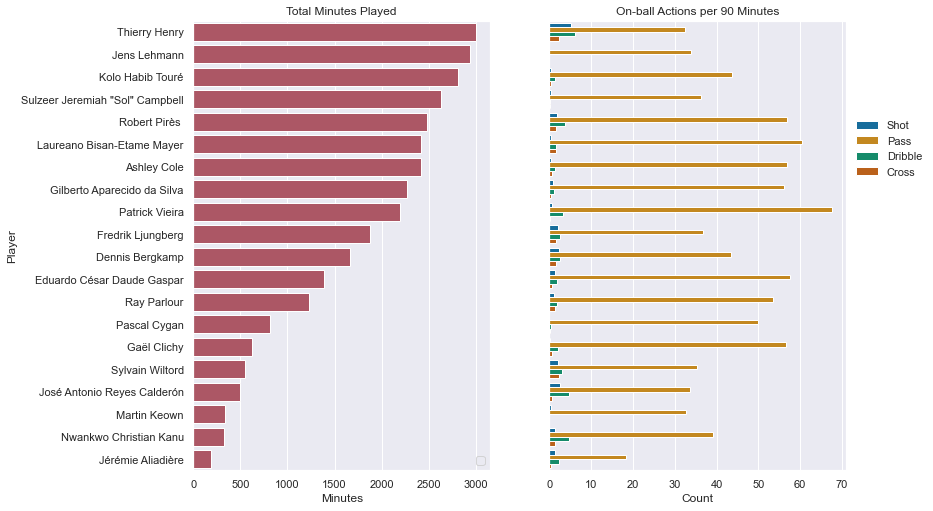

In [11]:
projplot.plt_actions_distribution(master_df, total_minutes_df)

---

### **04. Determining Clustering Structure**

---

Before designing player vectors, we must first assess the clusterability of our dataset for an underlying clustering structure. Failure to do so would result in a weary and ill-supported analysis.

To do this, I gather relevant attributes per action type and create four `tsne_<action-type>` dataframes per action type to hold this information as well as matching outcome labels. These dataframes will be fed into a t-SNE plot before being fed into a clustering algorithm to model a basic clustering structure of the action type.

In [12]:
# tsne dataframe for shot type
tsne_shot = master_df[master_df['type'] == 'Shot'][['shot_outcome', 'shot_statsbomb_xg', 'location_x', 'location_y']]
tsne_shot[['location_x', 'location_y']] = tsne_shot[['location_x', 'location_y']].astype('float64')
tsne_shot['outcome'] = np.where(tsne_shot['shot_outcome'] == 'Goal', 1, 0)

# tsne dataframe for pass type
tsne_pass = master_df[master_df['type'] == 'Pass'][['pass_outcome', 'pass_shot_assist', 'pass_technique', 'location_x', 'location_y', 'pass_end_x', 'pass_end_y']]
tsne_pass[['location_x', 'location_y']] = tsne_pass[['location_x', 'location_y']].astype('float64')
tsne_pass[['pass_end_x', 'pass_end_y']] = tsne_pass[['pass_end_x', 'pass_end_y']].astype('float64')
tsne_pass['outcome'] = np.where(master_df[master_df['type'] == 'Pass']['pass_outcome'].isna(), 'Complete', 'Incomplete')

# tsne dataframe for dribble type
tsne_dribble = master_df[master_df['type'] == 'Dribble'][['dribble_outcome', 'location_x', 'location_y']]
tsne_dribble[['location_x', 'location_y']] = tsne_dribble[['location_x', 'location_y']].astype('float64')

# tsne dataframe for cross type
tsne_cross = master_df[master_df['type'] == 'Cross'][['location_x', 'location_y', 'pass_end_x', 'pass_end_y']]
tsne_cross[['location_x', 'location_y']] = tsne_cross[['location_x', 'location_y']].astype('float64')
tsne_cross[['pass_end_x', 'pass_end_y']] = tsne_cross[['pass_end_x', 'pass_end_y']].astype('float64')
tsne_cross['outcome'] = np.where(master_df[master_df['type'] == 'Cross']['pass_outcome'].isna(), 'Complete', 'Incomplete')

##### **i. Selecting t-SNE Plots**

Below, we perform the same process for each action types:
- scale the dataset to avoid unequal influence on t-SNE algorithm's clustering abilities
- pass the scaled dataset into the t-SNE algorithm and generate an $p \times r$ grid of $p$ perplexity values and $r$ random state values
- select the t-SNE plot that best displays a clustering structure
- pass selected t-SNE plot into a clustering algorithm and determine the best parameters for said clustering algorithm
- map results back to pitch coordinates to view where clusters occur on the pitch and try to explain what makes the clusters similar within and different between themselves.

##### **a. Action Type: Shot**

Let's plot t-SNE plots for the shot action type across an array of perplexity values provided below and two random states provided in the function definition.

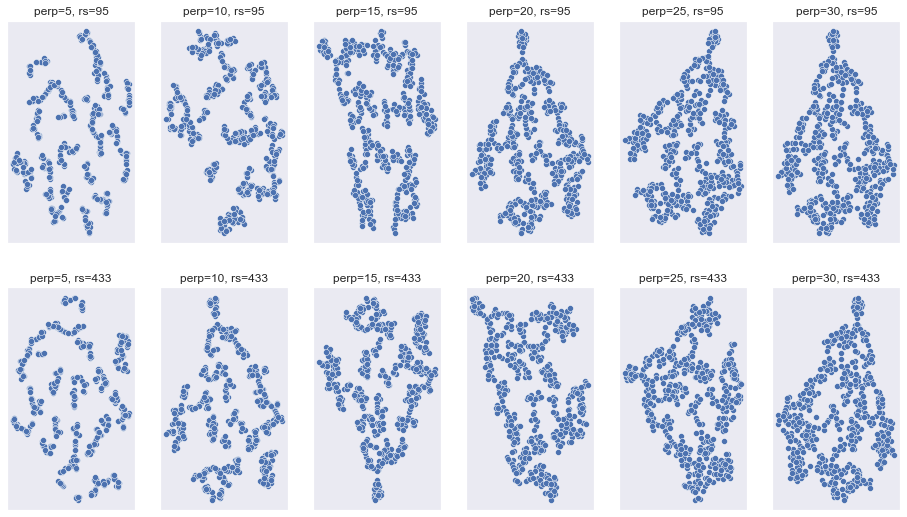

In [13]:
tsne_shot_scaled = pd.DataFrame(
    StandardScaler().fit_transform(tsne_shot.drop(columns=['shot_outcome', 'outcome'])),
    columns=['shot_statsbomb_xg', 'location_x', 'location_y']
)

f = projplot.plt_tsne_subplots(
    tsne_shot_scaled,
    perps=[5,10,15,20,25,30]
)

plt.show()

Given these twelve plots, we can reasonably conclude that there is a clustering structure present in the dataframe, and it seems like the favorable (`perp`, `rs`) pairing occurs at (25, 95). Let's learn more about this clustering to identify what makes our clusters unique.

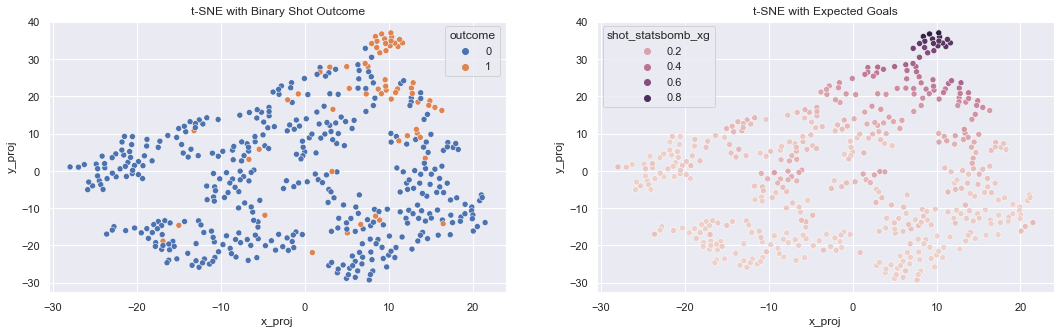

In [14]:
perp, rs = 25, 95

shot_tsne = TSNE(n_components=2, perplexity=perp, random_state=rs)
shot_tsne_fit = shot_tsne.fit_transform(tsne_shot_scaled)
shot_tsne_data = pd.DataFrame(shot_tsne_fit, columns=['x_proj', 'y_proj'])

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,5))
shot_tsne_data['shot_statsbomb_xg'] = tsne_shot['shot_statsbomb_xg'].reset_index(drop=True)
shot_tsne_data['outcome'] = tsne_shot['outcome'].reset_index(drop=True)
sns.scatterplot(x='x_proj', y='y_proj', hue='outcome', data=shot_tsne_data, ax=axs[0])
sns.scatterplot(x='x_proj', y='y_proj', hue='shot_statsbomb_xg', data=shot_tsne_data, ax=axs[1])
axs[0].set_title('t-SNE with Binary Shot Outcome')
axs[1].set_title('t-SNE with Expected Goals')
plt.show()

Interesting that goals scored as well as goals likely to be scored (expected goals) appears in its own cluster. Seems like k-means will help us pick out that cluster as well as some other subclusters within the plots above. 

Let's create a list that will capture the inertia across an array of `k` cluster values and notice where a profound elbow occurs. In the case of a tie, I will show preference for a lower `k` value.

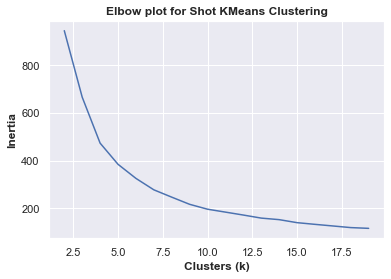

In [15]:
inertia_list = [
    KMeans(n_clusters=k).fit(tsne_shot_scaled).inertia_
    for k in range(2,20)
]

plt.figure(figsize=(6, 4))
plt.plot(range(2,20), inertia_list)
plt.title('Elbow plot for Shot KMeans Clustering', weight='bold')
plt.xlabel('Clusters (k)', weight='semibold')
plt.ylabel('Inertia', weight='semibold')
plt.show()

Given the plot above, we notice a moderate elbow at `k = 4` clusters. Let's plug that in to a `KMeans` class instance and fit it with our scaled `tsne_shot_scaled` dataframe and observe our results.

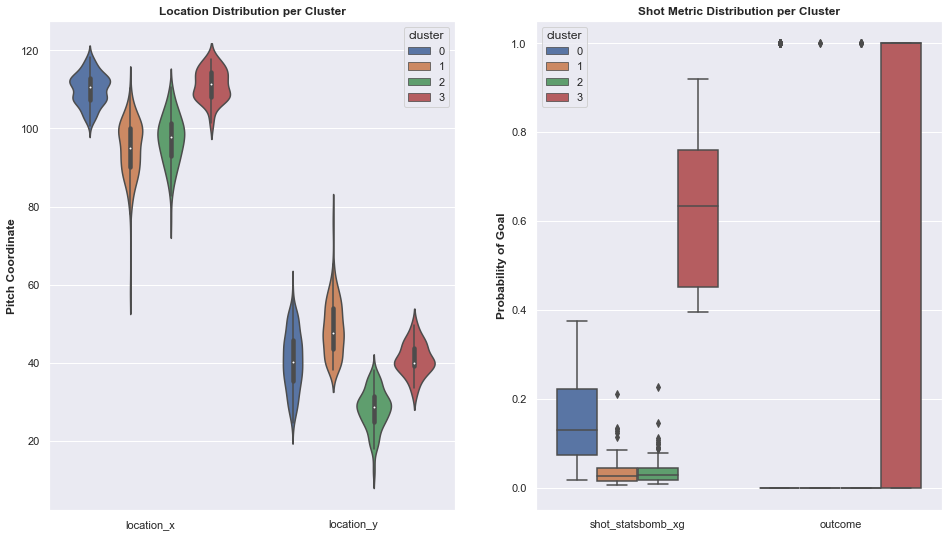

In [16]:
km = KMeans(n_clusters=4, random_state=430).fit(tsne_shot_scaled)
tsne_shot['cluster'] = km.labels_
tsne_shot_melted = pd.melt(frame=tsne_shot, id_vars='cluster', value_vars=['shot_statsbomb_xg', 'location_x', 'location_y', 'outcome'])
tsne_shot_location = tsne_shot_melted[tsne_shot_melted['variable'].isin(['location_x','location_y'])]
tsne_shot_outcomes = tsne_shot_melted[~tsne_shot_melted['variable'].isin(['location_x','location_y'])]

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,9))

sns.violinplot(x='variable', y='value', hue='cluster', data=tsne_shot_location, ax=axs[0])
axs[0].set_title('Location Distribution per Cluster', weight='bold')
axs[0].set_xlabel('')
axs[0].set_ylabel('Pitch Coordinate', weight='semibold')

sns.boxplot(x='variable', y='value', hue='cluster', data=tsne_shot_outcomes, ax=axs[1])
axs[1].set_title('Shot Metric Distribution per Cluster', weight='bold')
axs[1].set_xlabel('')
axs[1].set_ylabel('Probability of Goal', weight='semibold')

plt.show()

<Axes:xlabel='location_x', ylabel='Density'>

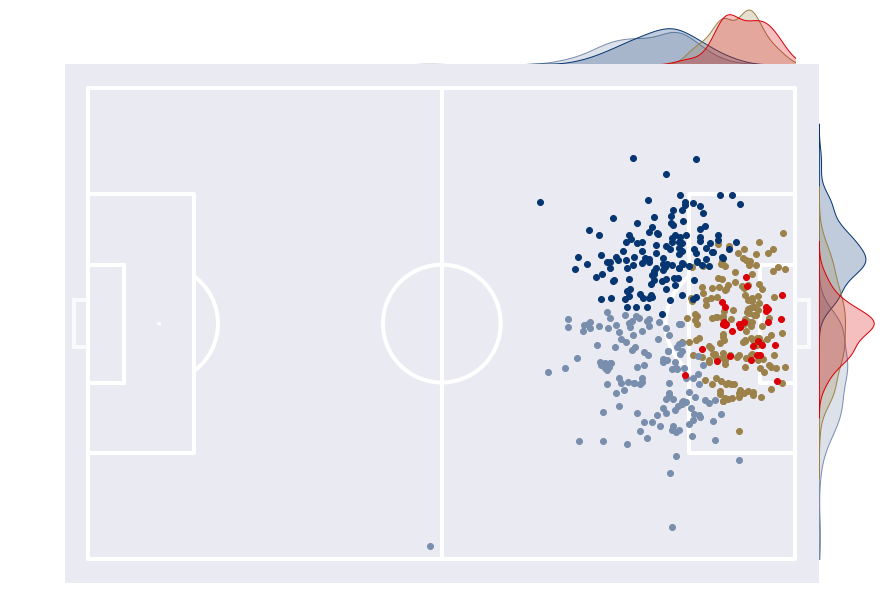

In [17]:
tsne_c0 = tsne_shot[tsne_shot['cluster'] == 0]
tsne_c1 = tsne_shot[tsne_shot['cluster'] == 1]
tsne_c2 = tsne_shot[tsne_shot['cluster'] == 2]
tsne_c3 = tsne_shot[tsne_shot['cluster'] == 3]

pitch = Pitch(
    goal_type='box',
    goal_alpha=0.8,
    linewidth=4)
fig, axs = pitch.jointgrid(figheight=10, left=None, bottom=None, grid_height=0.8,
                           axis=False,  # turn off title/ endnote/ marginal axes
                           # plot without endnote/ title axes
                           title_height=0, endnote_height=0)
# increase number of levels for a smoother looking heatmap
pitch.scatter(tsne_c0['location_x'], tsne_c0['location_y'], ax=axs['pitch'], c='#9C824A', marker='o')
pitch.scatter(tsne_c1['location_x'], tsne_c1['location_y'], ax=axs['pitch'], c='#798ead')
pitch.scatter(tsne_c2['location_x'], tsne_c2['location_y'], ax=axs['pitch'], c='#063672')
pitch.scatter(tsne_c3['location_x'], tsne_c3['location_y'], ax=axs['pitch'], c='#DB0007')
# kdeplot on marginal axes
sns.kdeplot(y=tsne_c1['location_y'], ax=axs['right'], color='#798ead', shade=True)
sns.kdeplot(x=tsne_c1['location_x'], ax=axs['top'], color='#798ead', shade=True)
sns.kdeplot(y=tsne_c2['location_y'], ax=axs['right'], color='#063672', shade=True)
sns.kdeplot(x=tsne_c2['location_x'], ax=axs['top'], color='#063672', shade=True)
sns.kdeplot(y=tsne_c0['location_y'], ax=axs['right'], color='#9C824A', shade=True)
sns.kdeplot(x=tsne_c0['location_x'], ax=axs['top'], color='#9C824A', shade=True)
sns.kdeplot(y=tsne_c3['location_y'], ax=axs['right'], color='#DB0007', shade=True)
sns.kdeplot(x=tsne_c3['location_x'], ax=axs['top'], color='#DB0007', shade=True)

Takeaways from the shot t-SNE plots: we've picked out four clusters that are partially based on the shot's location on the pitch (inside/outside the box, left/right of the goal) as well as the quality of the shot (high or low probability to score). Our violinplots and boxplots propose this idea and the mapping and distributions on our pitch confirm it.

##### **b. Action Type: Pass**

Passes will undoubtedly be trickier to cluster than shots. Not only do they occur at a higher rate than shots, but they occur over the entire pitch and have no immediate metric like `shot_statsbomb_xg` to measure the quality of said pass, making it difficult to notice a clustering structure simply by looking at the distribution. Regardless, let's test this hypothesis by following the same procedure as before.

One minor change we will make is instead of passing all 17,132 passes into the t-SNE algorithm, we'll instead pass a sample of 2000 points for computational sakes. This is done using the `np.random()` suite to generate random indices as seen below.

In [18]:
np.random.seed(12345)
samples = np.random.choice(range(tsne_pass.shape[0]), size=2000, replace=False)
tsne_pass_sample = tsne_pass.iloc[samples, :]

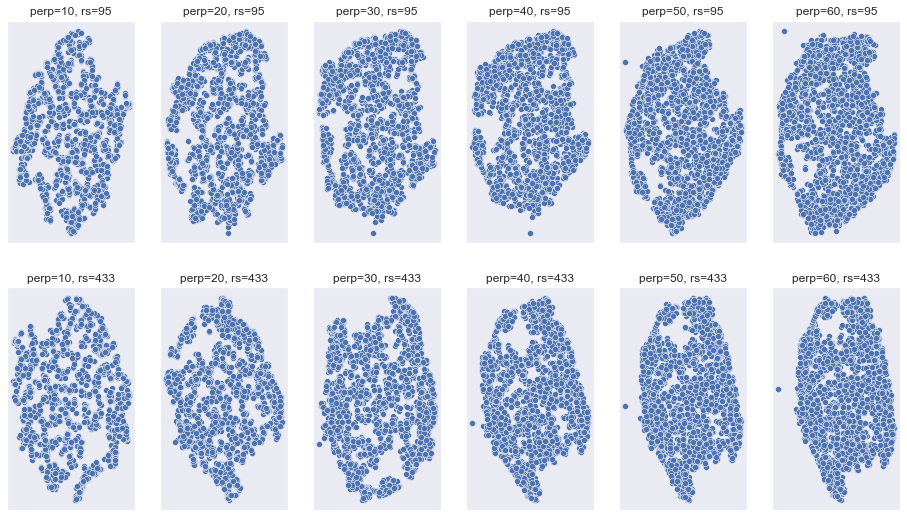

In [19]:
f = projplot.plt_tsne_subplots(
    tsne_pass_sample,
    perps=[10,20,30,40,50,60],
    drop_cols=['outcome', 'pass_outcome', 'pass_shot_assist', 'pass_technique']
)

plt.show()

Based on the plots above, we notice a couple areas on the t-SNE plot where there is a much greater concentration of points than others, specifically along the edges of the plot as well as a ball of points near the top. Although k-means and other noise-sensitive algorithms would struggle with a clustering structure like such, graph-based clustering algorithms like DBSCAN perform considerably better after tuning for the right parameters. (I mean density is built into its name.)

Given that let's pick out our preferred (`perp`, `rs`) pairing and pass it into a DBSCAN instance. In order to do so, we will first compute the hopkin's statistic for a sample of parameter pairings to see which pair has the greatest clustering structure.

In [20]:
for perp, rs in zip([10, 20, 30, 40, 50, 60], [95,433,433,433,95,95]):
    # perp, rs = 50, 95
    pass_tsne = TSNE(n_components=2, perplexity=perp, random_state=rs)
    pass_tsne_fit = pass_tsne.fit_transform(tsne_pass_sample.drop(columns=['outcome', 'pass_outcome', 'pass_shot_assist', 'pass_technique']))
    pass_tsne_data = pd.DataFrame(pass_tsne_fit, columns=['proj_x', 'proj_y'])
    pass_tsne_data['outcome'] = tsne_pass_sample['outcome'].reset_index(drop=True)

    num_trials=10
    hopkins_stats=[]
    for i in range(0,num_trials):
        n = len(tsne_pass_sample)
        p = int(0.1 * n)
        hopkins_stats.append(hopkins(tsne_pass_sample.drop(columns=['outcome', 'pass_outcome', 'pass_shot_assist', 'pass_technique']),p))
    
    print(f'{perp}, {rs}\t-> {np.mean(hopkins_stats)}')

perp, rs = 20, 433
pass_tsne = TSNE(n_components=2, perplexity=perp, random_state=rs)
pass_tsne_fit = pass_tsne.fit_transform(tsne_pass_sample.drop(columns=['outcome', 'pass_outcome', 'pass_shot_assist', 'pass_technique']))
pass_tsne_data = pd.DataFrame(pass_tsne_fit, columns=['proj_x', 'proj_y'])
pass_tsne_data['outcome'] = tsne_pass_sample['outcome'].reset_index(drop=True)

10, 95	-> 0.2646116635744119
20, 433	-> 0.2692581148447414
30, 433	-> 0.2614146142141217
40, 433	-> 0.2662866771849598
50, 95	-> 0.2662397624727455
60, 95	-> 0.26029702972544194


Considering the hopkin's statistic sits on a range of [0, 0.5], where smaller values indicate a strong clustering structure and higher values indicate a weak clustering structure, sitting right in the middle leaves us in a spot of uncertainty. This could (and most likely is) in large part due to the similarity in the t-SNE output and the pass distribution. Notice, the most dense regions of the t-SNE plot seem to occur on the sidelines (the two vertical bars) and near the goalkeeper (the lone ball of points near the top of most clusters), and the parameter pairing that picks this out the most - although not by a considerable margin - is the (20, 433) pairing above.

Although not considered in this analysis, we could improve the clustering structure by considering the pass patterns, otherwise referred to as passing/receiving networks, that players on a given team develop as they build offensive play. Doing so would weight passes performed in similar areas equally, allowing us to discretize a player's passing behavior "in order to find each individual’s unique linear combination of passing/receiving patterns" (Sattari et. al., 2021), a method that we will consider implementing later.

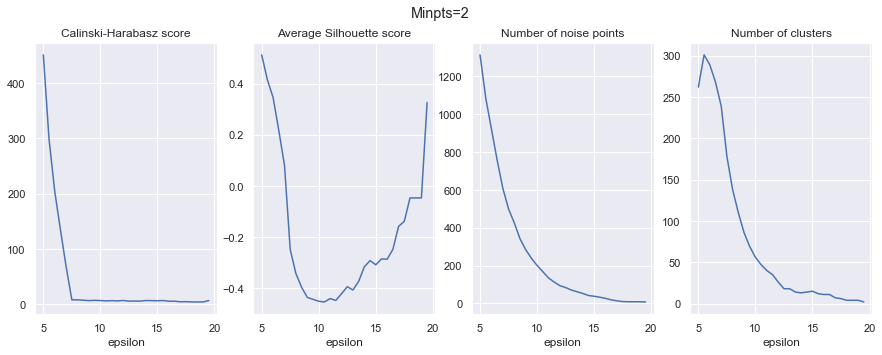

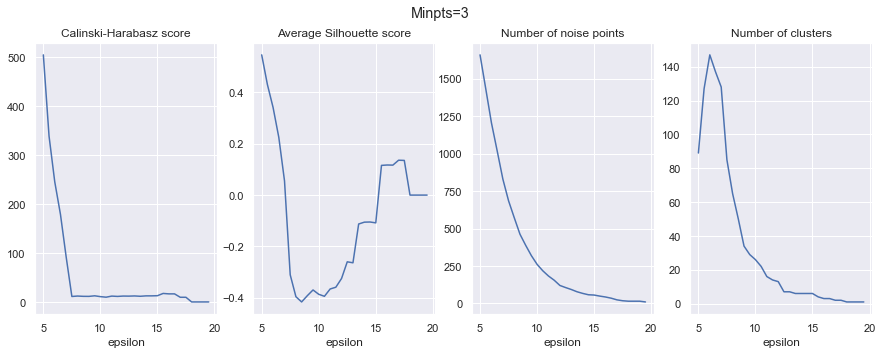

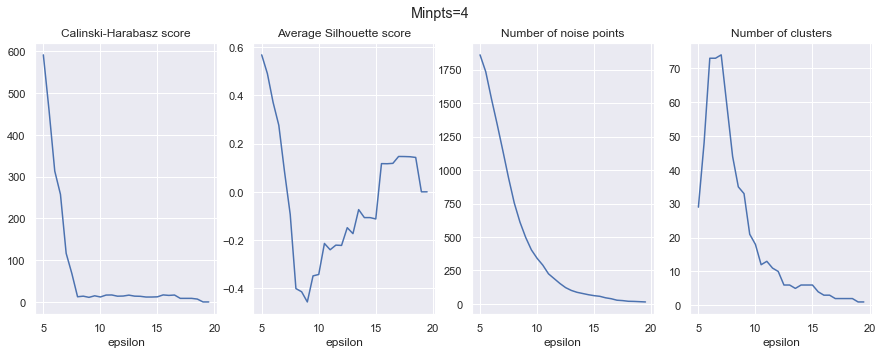

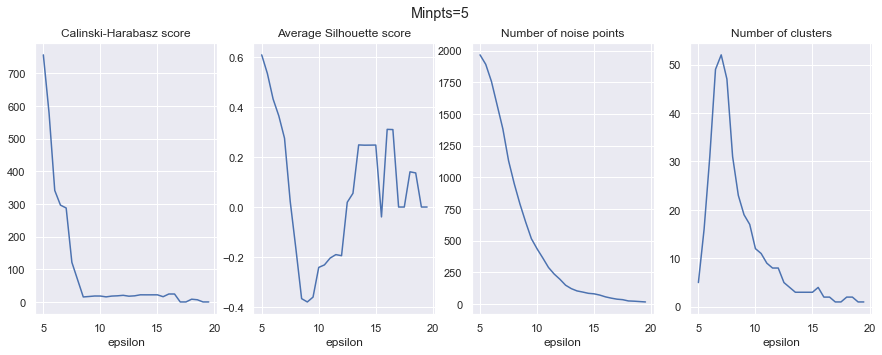

In [21]:
import warnings
warnings.filterwarnings("ignore")


X_noisy = tsne_pass_sample.drop(columns=['outcome', 'pass_outcome', 'pass_shot_assist', 'pass_technique'])

# Perform the preliminary analysis
for minpts in [2,3,4,5]:
    calinski_harabazs_scores = []
    silhouette_scores = []
    num_clusters = []
    num_noise_points = []


    num_clusters_p = []
    n_noise_points_p = []
    silhouette_scores_p = []
    calinski_harabazs_scores_p = []

    for eps in np.arange(5, 20, 0.5):
        #Cluster the dataset using DBSCAN
        dst = DBSCAN(eps=eps, min_samples=minpts, metric='euclidean')
        tsne_pass_sample['predicted_cluster'] = dst.fit_predict(X_noisy)

        #Filter out the noise points
        df_noisy_no_noise=tsne_pass_sample[tsne_pass_sample['predicted_cluster']!=-1]
        
        #Get the number of clusters in the clustering
        k=len(tsne_pass_sample['predicted_cluster'].value_counts())-1
        num_clusters.append(k)
        
        #Get the number of noise points
        noise_point_num=len(tsne_pass_sample[tsne_pass_sample['predicted_cluster']==-1])
        num_noise_points.append(noise_point_num)
        
        #Average silhouette score of the clustering
        if k>1:
            silhouette_scores.append(silhouette_score(X_noisy[tsne_pass_sample['predicted_cluster']!=-1],
                                                              tsne_pass_sample[tsne_pass_sample['predicted_cluster']!=-1]['predicted_cluster']))
        else:
            #(If there is only one cluster, then the average silhouette score is 0)
            silhouette_scores.append(0)
        #Calinski-Harabasz score of the clsutering
        if k>1:
            calinski_harabazs_scores.append(calinski_harabasz_score(X_noisy[tsne_pass_sample['predicted_cluster']!=-1],
                                                                        tsne_pass_sample[tsne_pass_sample['predicted_cluster']!=-1]['predicted_cluster']))
        else:
            calinski_harabazs_scores.append(0)
        
    # Show the results of the preliminary analysis
    fig, ax = plt.subplots(1, 4, figsize=(15, 5), sharex=True)

    eps = np.arange(5, 20, 0.5)
    fig.suptitle('Minpts=%s'%minpts)
    ax[0].plot(eps, calinski_harabazs_scores)
    ax[1].plot(eps, silhouette_scores)    
    ax[2].plot(eps, num_noise_points)
    ax[3].plot(eps, num_clusters)

    ax[0].set_title('Calinski-Harabasz score')
    ax[1].set_title('Average Silhouette score')
    ax[2].set_title('Number of noise points')
    ax[3].set_title('Number of clusters')

    #ax[0].set_yticks(np.arange(5, 60, 7))
    ax[0].set_xlabel('epsilon')
    ax[1].set_xlabel('epsilon')
    ax[2].set_xlabel('epsilon')
    ax[3].set_xlabel('epsilon')
    plt.show()

Looking at our plots above, we should make note of the plots we are outputting. For each `mnpts` level, we will be focusing on the Calinski-Harabasz score (a metric defining the ratio of between-cluster dispersion and within-cluster dispersion), the average silhouette score (a metric defining how likely all points across all clusters are to be a part of their assigned cluster), the number of noise points (points that are not core points nor neighbor points), and the number of clusters. We will look for an `eps` value such that we maximize the first two metrics and minimize the number of noise points such that we are left with a reasonable number of clusters.

Given the output above, we take particular notice of the (`eps`, `minpts`) pairing of (7.5, 4) because, when plotted, is the last pairing that separates the two dense clusters before merging them together (a mentioned drawback of DBSCAN). Given this pairing, let's observe which points the algorithm picks apart.

In [22]:
dst = DBSCAN(eps=7.5, min_samples=4, metric='euclidean')
tsne_pass_sample['predicted_cluster'] = dst.fit_predict(X_noisy)
tsne_pass_sample['predicted_cluster'].value_counts().sort_values(ascending=False)[:5]

-1     941
 0     430
 3     202
 14     47
 9      33
Name: predicted_cluster, dtype: int64

Using the two most populated clusters defined above, we can observe where they occur on the pitch in the plot below. As suspected, the prominent clusters we noticed above are indeed passes along that are generally along the sidelines, a distinct boundary of the pitch. Again, this confirms the difficulty in plotting the passing data given the lack of uniqueness from one pass to the next, an attribute that was not present for shots (and same will be true for crosses).

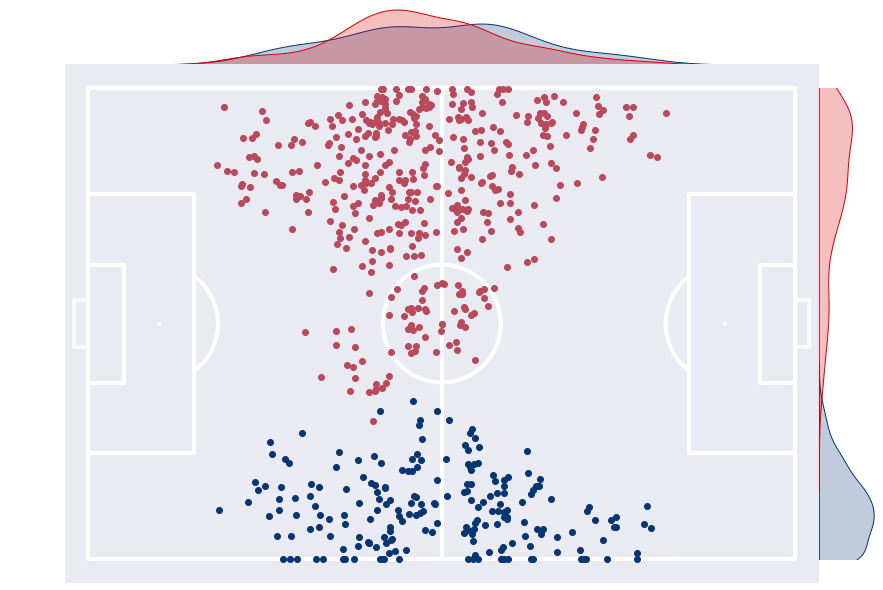

In [23]:
# shot_grouped_df = tsne_shot.groupby('cluster').agg('mean').reset_index()
tsne_c0 = tsne_pass_sample[tsne_pass_sample['predicted_cluster'] == 0]
tsne_c1 = tsne_pass_sample[tsne_pass_sample['predicted_cluster'] == 3]

pitch = Pitch(
    goal_type='box',
    goal_alpha=0.8,
    linewidth=4)
fig, axs = pitch.jointgrid(figheight=10, left=None, bottom=None, grid_height=0.8,
                           axis=False,  # turn off title/ endnote/ marginal axes
                           # plot without endnote/ title axes
                           title_height=0, endnote_height=0)
# increase number of levels for a smoother looking heatmap
pitch.scatter(tsne_c0['location_x'], tsne_c0['location_y'], ax=axs['pitch'], c='#ba495c', marker='o')
pitch.scatter(tsne_c1['location_x'], tsne_c1['location_y'], ax=axs['pitch'], c='#063672')
# kdeplot on marginal axes
sns.kdeplot(y=tsne_c1['location_y'], ax=axs['right'], color='#063672', shade=True)
sns.kdeplot(x=tsne_c1['location_x'], ax=axs['top'], color='#063672', shade=True)
sns.kdeplot(y=tsne_c0['location_y'], ax=axs['right'], color='#DB0007', shade=True)
sns.kdeplot(x=tsne_c0['location_x'], ax=axs['top'], color='#DB0007', shade=True)

plt.show()

##### **c. Action Type: Dribble**

Dribbles, like passes, occur across the entire pitch and, like crosses, do not possess some attached metric to detail the quality of said action. Simply looking for a clustering structure given the (x,y) coordinates of the dribble actions, we'd suspect a similar outcome to passes. Simply, there would be clusters defined by the boundaries of the pitch, although possibly less-defined since, like stated previously, there is not attached metric to describe the quality of the dribble.

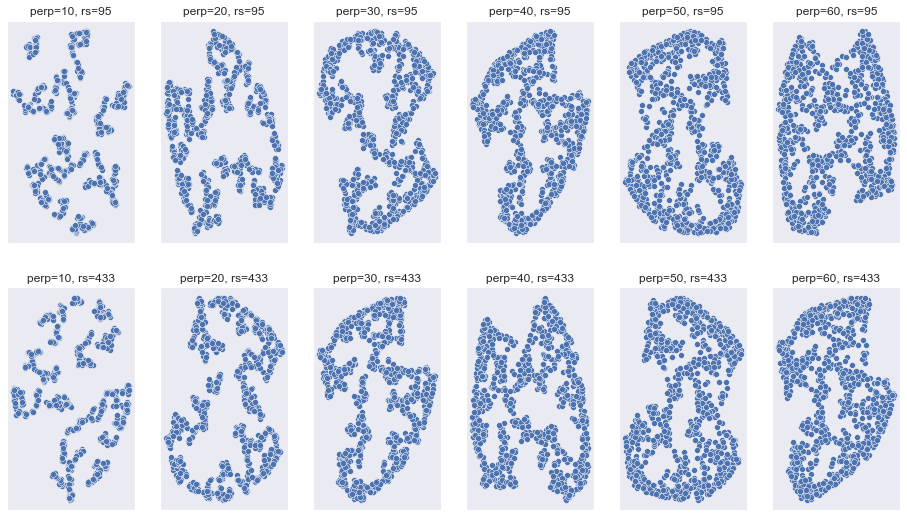

In [24]:
f = projplot.plt_tsne_subplots(
    tsne_dribble.drop(columns='dribble_outcome'),
    perps=[10,20,30,40,50,60]
)

plt.show()

Although the results above are not promising at first, we notice that these plots show spherical clusters at lower perplexity values and graph based clusters at higher perplexity values. Although we could continue with this clustering much like we did for passes, when we consider a drawback of DBSCAN, we notice that there are "bridge" points that connect our two dense regions; hence, given a large enough `epsilon` or small enough `min_points` parameter, we would connect the two dense regions and recongize them as one cluster. Hence, let's use KMeans at a lower perplexity value and observe our results.

Let's select the most clusterable parameter pairing (like we did above) and draw some inferences.

In [25]:
for perp, rs in zip([10, 20, 30, 40, 50, 60], [95,433,433,433,95,95]):
    # perp, rs = 50, 95
    dribble_tsne = TSNE(n_components=2, perplexity=perp, random_state=rs)
    dribble_tsne_fit = dribble_tsne.fit_transform(tsne_dribble.drop(columns='dribble_outcome'))
    dribble_tsne_data = pd.DataFrame(dribble_tsne_fit, columns=['x_proj', 'y_proj'])
    dribble_tsne_data['outcome'] = tsne_dribble['dribble_outcome'].reset_index(drop=True)


    num_trials=10
    hopkins_stats=[]
    for i in range(0,num_trials):
        n = len(tsne_pass_sample)
        p = int(0.1 * n)
        hopkins_stats.append(hopkins(dribble_tsne_data.drop(columns=['outcome']),p))
    
    print(f'{perp}, {rs}\t-> {np.mean(hopkins_stats)}')

# perp, rs = 20, 433
# pass_tsne = TSNE(n_components=2, perplexity=perp, random_state=rs)
# pass_tsne_fit = pass_tsne.fit_transform(tsne_pass_sample.drop(columns=['outcome', 'pass_outcome', 'pass_shot_assist', 'pass_technique']))
# pass_tsne_data = pd.DataFrame(pass_tsne_fit, columns=['proj_x', 'proj_y'])
# pass_tsne_data['outcome'] = tsne_pass_sample['outcome'].reset_index(drop=True)

10, 95	-> 0.09436294991702711
20, 433	-> 0.19177644315747566
30, 433	-> 0.2073970615968077
40, 433	-> 0.288679003082313
50, 95	-> 0.32589799441796324
60, 95	-> 0.3260506792009015


The most obvious parameter pairing occurs with (`perp`, `rs`) = (10, 95) given the near zero value (closer to zero resembles a greater clustering structure). Given that, let's select that as our parameter pair and cluster our dribble data.

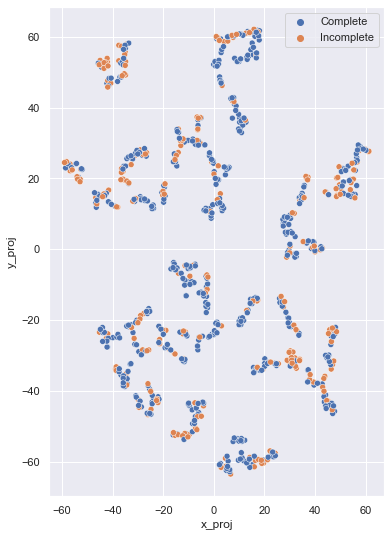

In [26]:
perp, rs = 10, 95

dribble_tsne = TSNE(n_components=2, perplexity=perp, random_state=rs)
dribble_tsne_fit = dribble_tsne.fit_transform(tsne_dribble.drop(columns='dribble_outcome'))
dribble_tsne_data = pd.DataFrame(dribble_tsne_fit, columns=['x_proj', 'y_proj'])
dribble_tsne_data['outcome'] = tsne_dribble['dribble_outcome'].reset_index(drop=True)

plt.figure(figsize=(6, 9))
sns.scatterplot(x='x_proj', y='y_proj', hue='outcome', data=dribble_tsne_data)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

Although the t-SNE plot doesn't show as distinct a clustering when we overlay the outcome of each dribble, we can still evaluate how the distribution of points changes as we pass the data into a clustering algorithm. Since the t-SNE plot shows spherical, mostly separated clusters, we'll use t-SNE and see what comes up in the results.

Same as before, we'll observe the elbow plot to determine the possible numbers of clusters, then observe the distribution of each cluster in grouped boxplots, then map the clusters onto their each dribble's pitch coordinates.

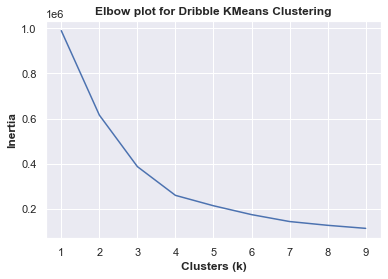

In [27]:
# km = KMeans(n_clusters=2, random_state=430).fit(tsne_dribble.drop(columns='dribble_outcome'))

inertia_list = [
    KMeans(n_clusters=k, random_state=430).fit(tsne_dribble.drop(columns='dribble_outcome')).inertia_
    for k in range(1,10)
]

plt.figure(figsize=(6, 4))
plt.plot(range(1,10), inertia_list)
plt.title('Elbow plot for Dribble KMeans Clustering', weight='bold')
plt.xlabel('Clusters (k)', weight='semibold')
plt.ylabel('Inertia', weight='semibold')
plt.show()

Interestingly enough, we observe almost identical elbows at `k=2`, `k=3`, and `k=4` clusters. Why don't we observe all of them?

Plotting the standard round of boxplots below, we see that the clusters are taking shape at different areas of the pitch which is not much of a surprise since they are being clustered on their location (again, there is no further qualifying variable - e.g. quality of dribble) which limits our clustering performance. We confirm this takeaway when looking at the scatterplots below, where the dribbles occur on different grids of the pitch, broken up by vertical and halfway lines much like how Arsenal organizes their attack.

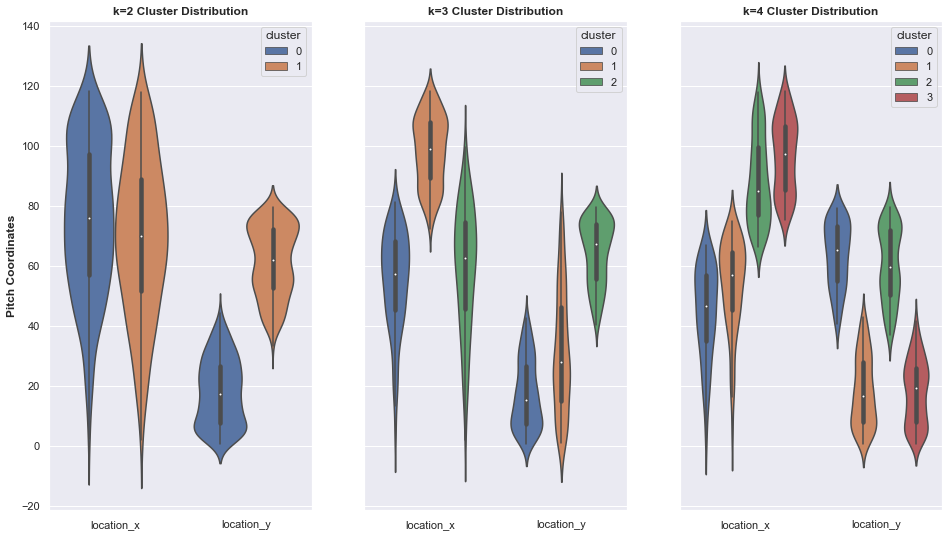

In [28]:
f, axs = plt.subplots(nrows=1, ncols=3, figsize=(16,9), sharey=True)

for k in range(2,5):
    km = KMeans(n_clusters=k, random_state=430).fit(tsne_dribble.drop(columns='dribble_outcome'))
    tsne_dribble['cluster'] = km.labels_
    dribble_melt = pd.melt(frame=tsne_dribble, id_vars='cluster', value_vars=['location_x', 'location_y', 'dribble_outcome'])
    sns_df = dribble_melt[dribble_melt['variable'].isin(['location_x', 'location_y'])]
    sns_df['value'] = sns_df['value'].astype('float64')
    sns.violinplot(x='variable', y='value', hue='cluster', data=sns_df, ax=axs[k-2])
    axs[k-2].set_title(f'k={k} Cluster Distribution', weight='bold')
    axs[k-2].set_xlabel('')
    axs[k-2].set_ylabel('')

axs[0].set_ylabel('Pitch Coordinates', weight='semibold')

plt.show()

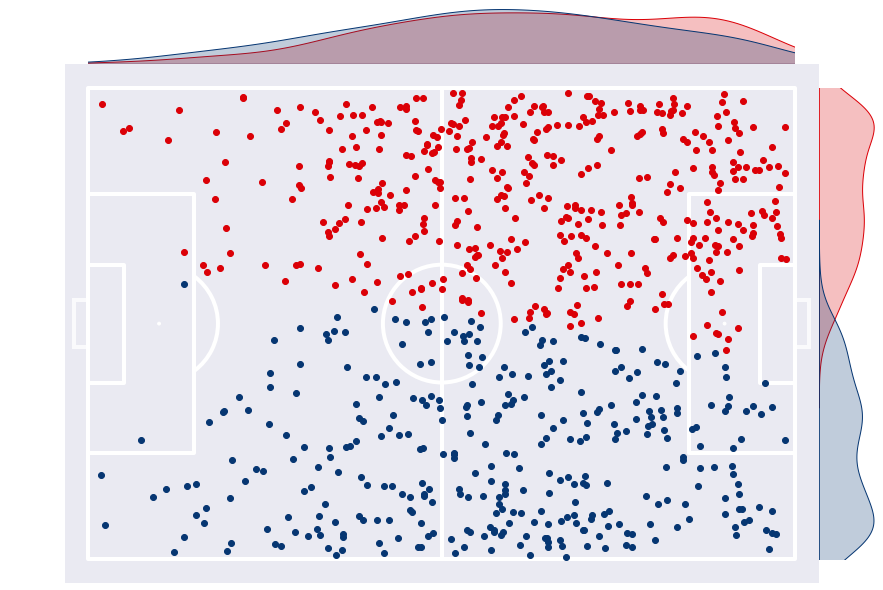

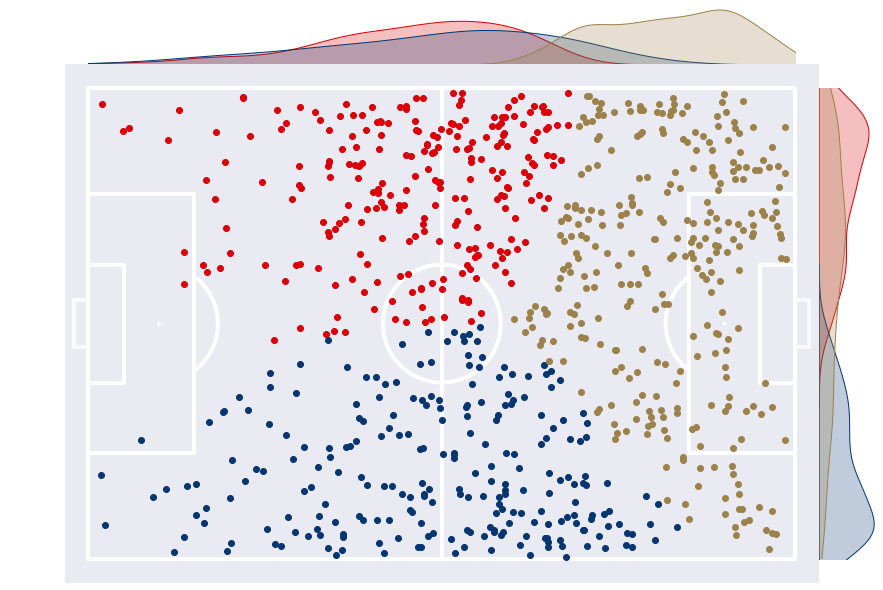

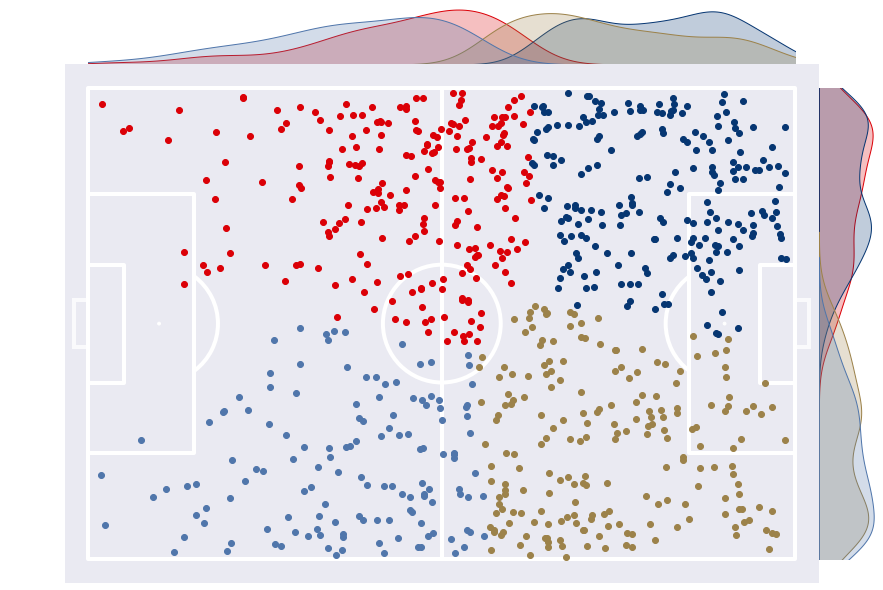

In [29]:
colors = ['#DB0007', '#063672', '#9C824A', '#5076ab']

# increase number of levels for a smoother looking heatmap
for k in range(2, 5):
    pitch = Pitch(
        goal_type='box',
        goal_alpha=0.8,
        linewidth=4)
    fig, axs = pitch.jointgrid(figheight=10, left=None, bottom=None, grid_height=0.8,
                            axis=False,  # turn off title/ endnote/ marginal axes
                            # plot without endnote/ title axes
                            title_height=0, endnote_height=0)
    
    km = KMeans(n_clusters=k, random_state=430).fit(tsne_dribble.drop(columns='dribble_outcome'))
    tsne_dribble['cluster'] = km.labels_
    
    for j, c in enumerate(tsne_dribble['cluster'].unique()):
        pitch_df = tsne_dribble[tsne_dribble['cluster'] == c]
        pitch.scatter(pitch_df['location_x'], pitch_df['location_y'], ax=axs['pitch'], c=colors[j], marker='o')
        # kdeplot on marginal axes
        sns.kdeplot(y=pitch_df['location_y'], ax=axs['right'], color=colors[j], shade=True)
        sns.kdeplot(x=pitch_df['location_x'], ax=axs['top'], color=colors[j], shade=True)
    plt.show()

##### **d. Action Type: Cross**

For our final action type, we would be very shocked if `KMeans(n_cluster=2)` was not our final result. Per the distribution we observed in Section 2, there are two cohesive, well-separated clusters that occur in narrowly-defined regions of the pitch. Let's pass it into the t-SNE algorithm and confirm our hypothesis.

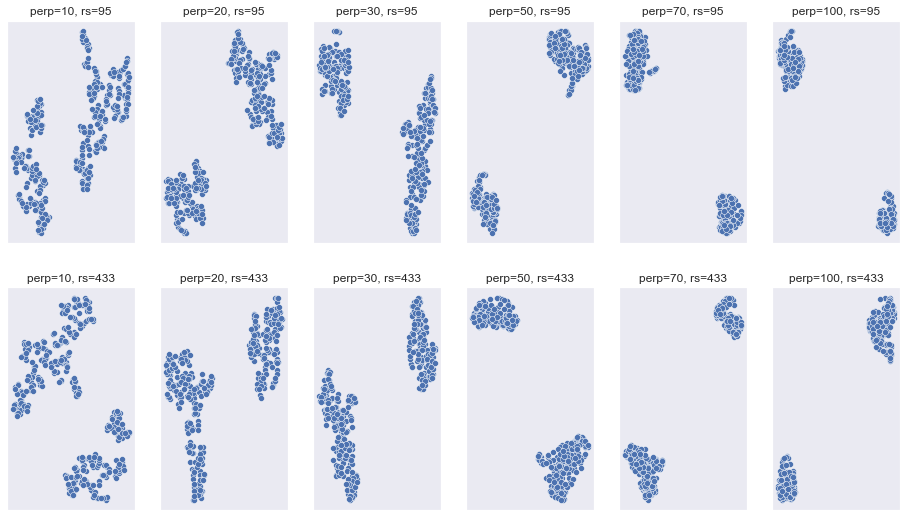

In [30]:
f = projplot.plt_tsne_subplots(
    tsne_cross,
    perps=[10,20,30,50,70,100],
    drop_cols=['outcome']
)

plt.show()

Beautiful - our hypothesis looks pretty correct if you ask me. One interesting note is in the (70, 433) plot, the upper cluster seems to split into two almost. Although this isn't clear in other clusters, we can keep an eye out for it later as it can possibly be a subcluster within its own cluster (or a quirk of this random state). Let's pass our dataset into KMeans with two clusters and see what results we are able to obtain. Since we are much more certain of our results than our shot action type, we'll pass the elbow plot and go straight into clustering.

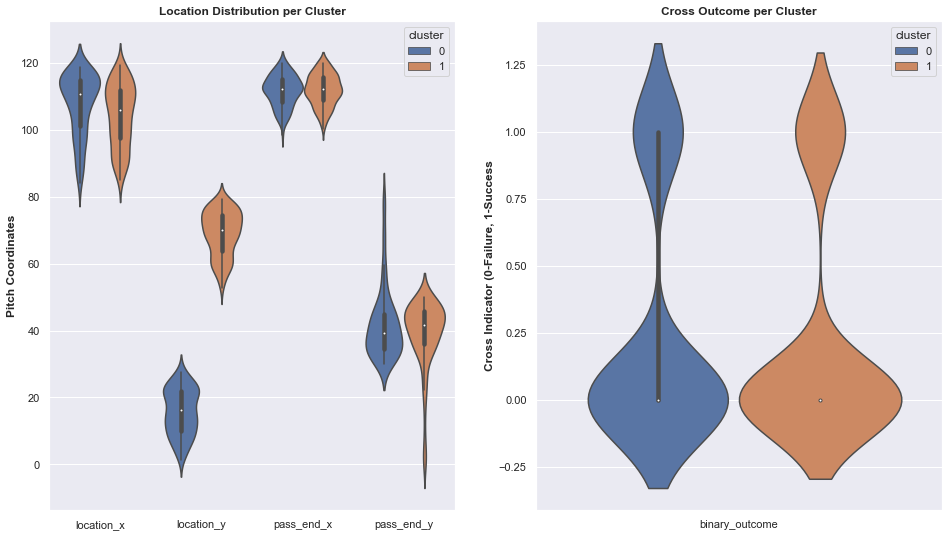

In [31]:
km = KMeans(n_clusters=2, random_state=430).fit(tsne_cross.drop(columns='outcome'))
tsne_cross['cluster'] = km.labels_
tsne_cross['binary_outcome'] = np.where(tsne_cross['outcome'] == 'Complete', 1, 0)
tsne_cross_melt = pd.melt(frame=tsne_cross, id_vars='cluster', value_vars=['location_x', 'location_y', 'pass_end_x', 'pass_end_y', 'binary_outcome'])

f,axs = plt.subplots(nrows=1, ncols=2, figsize=(16,9))

sns.violinplot(x='variable', y='value', hue='cluster', data=tsne_cross_melt[~tsne_cross_melt['variable'].isin(['binary_outcome'])], ax=axs[0])
axs[0].set_title('Location Distribution per Cluster', weight='bold')
axs[0].set_xlabel('')
axs[0].set_ylabel('Pitch Coordinates', weight='semibold')

sns.violinplot(x='variable', y='value', hue='cluster', data=tsne_cross_melt[tsne_cross_melt['variable'].isin(['binary_outcome'])], ax=axs[1])
axs[1].set_title('Cross Outcome per Cluster', weight='bold')
axs[1].set_xlabel('')
axs[1].set_ylabel('Cross Indicator (0-Failure, 1-Success', weight='semibold')

plt.show()

<Axes:xlabel='location_x', ylabel='Density'>

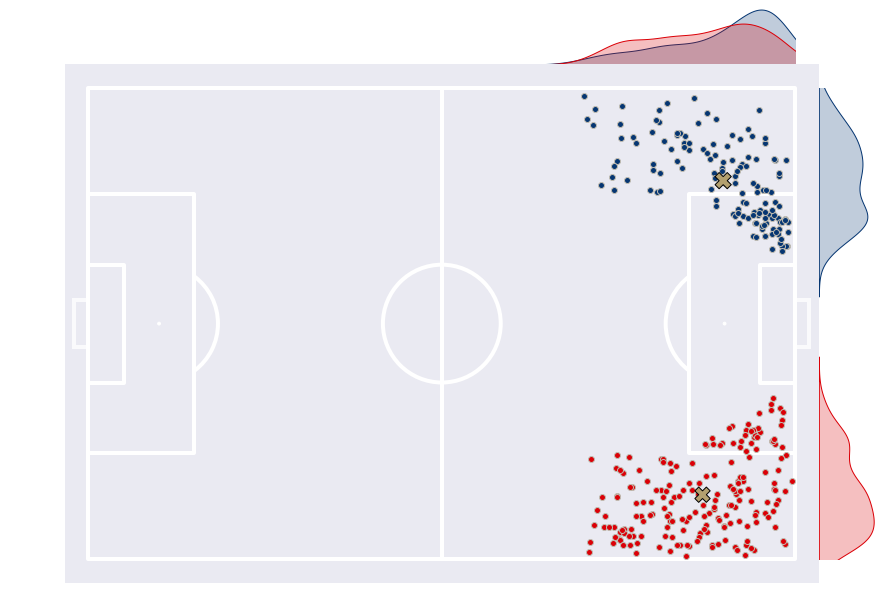

In [32]:
# shot_grouped_df = tsne_shot.groupby('cluster').agg('mean').reset_index()
tsne_cross_c0 = tsne_cross[tsne_cross['cluster'] == 0]
tsne_cross_c1 = tsne_cross[tsne_cross['cluster'] == 1]
cross_grouped = tsne_cross.groupby('cluster').agg('mean').reset_index()

pitch = Pitch(
    goal_type='box',
    goal_alpha=0.8,
    linewidth=4)
fig, axs = pitch.jointgrid(figheight=10, left=None, bottom=None, grid_height=0.8,
                           axis=False,  # turn off title/ endnote/ marginal axes
                           # plot without endnote/ title axes
                           title_height=0, endnote_height=0)
# increase number of levels for a smoother looking heatmap
pitch.scatter(tsne_cross_c0['location_x'], tsne_cross_c0['location_y'], ax=axs['pitch'], c='#063672', edgecolor='#bfbbb0')
pitch.scatter(tsne_cross_c1['location_x'], tsne_cross_c1['location_y'], ax=axs['pitch'], c='#DB0007', edgecolor='#bfbbb0')
pitch.scatter(cross_grouped['location_x'], cross_grouped['location_y'], ax=axs['pitch'], c='#b3a06f', edgecolor='#000000', marker='X', s=cross_grouped['binary_outcome'] * 1000)
# kdeplot on marginal axes
sns.kdeplot(y=tsne_cross_c0['location_y'], ax=axs['right'], color='#063672', shade=True)
sns.kdeplot(x=tsne_cross_c0['location_x'], ax=axs['top'], color='#063672', shade=True)
sns.kdeplot(y=tsne_cross_c1['location_y'], ax=axs['right'], color='#DB0007', shade=True)
sns.kdeplot(x=tsne_cross_c1['location_x'], ax=axs['top'], color='#DB0007', shade=True)

Takeaways from the cross action type: we confirm our initial suspicions that `KMeans(n_clusters=2)` suits our cross clustering structure the best. Even though there is no quality metric to further learn more about these clusters, the location is enough to cluster the action type.

---

### **05. Converting Event Stream Data to Player Heatmaps**

---

##### **i. Constructing Player Heatmaps**

Now that we've confirmed that our dataset is clusterable, let's get on with our analysis by designing our player vectors. Let's create a dictionary with all four on-ball action types as keys which will collect each player's compressed heatmap for said action type.

In [33]:
# keys are action types, values will be dataframes containing each player's compressed heatmap
nmf_dict = {'Pass':[], 'Shot':[], 'Dribble':[], 'Cross':[]}

The first step in creating a player's compressed heatmap is creating a player's uncompressed heatmap. Each uncompressed heatmap will consist of a 24-by-25 matrix, where each cell (`i`, `j`) will represent the weighted frequency of a player committing one of the four on-ball actions in that cell. Examples are seen below.

Notice, we apply the `gaussian_filter` to each heatmap matrix before returning it. This is to convey connection (ie. create a neighborhood) between grids on the heatmap.

In [34]:
def player_action_heatmap(player, action, nrows=24, ncols=25):
    if player not in player_dict:
        print(f'Invalid player entry: {player} not found')
        return None
    if action not in player_dict[player]:
        print(f'Invalid action type for {player}: {action} not found')
        return None
    
    player_total_mins = np.sum([total_minutes_dict['minutes'][tup] for tup in total_minutes_dict['minutes'] if tup[0] == player])

    # heatmap_dict = {'Pass':[], 'Shot':[], 'Dribble':[], 'Cross':[]}
    # create empty dataframe of specified dimensions
    heatmap_matrix = np.zeros(shape=(nrows, ncols))

    # partition the field evenly (could be altered depending on weights
    # of different grid patterns on the field)
    row_divs = np.round(np.linspace(0, 80, nrows), 2)
    col_divs = np.round(np.linspace(0, 120, ncols), 2)

    # iterate over rows and assign count to specific cell grid
    for _, action in player_dict[player][action][['location_x', 'location_y']].iterrows():
        # assign to closest row grid cell and column grid cell
        grid_row = np.abs(row_divs - np.float64(action['location_y'])).argmin()
        grid_col = np.abs(col_divs - np.float64(action['location_x'])).argmin()
        # argmin index out of bounds if closest to upper bound (nrows, ncols)
        if grid_row == nrows: grid_row -= 1
        if grid_col == ncols: grid_col -= 1
        # update corresponding grid cell (of player-action combo) by one adj. 90-min frequency
        heatmap_matrix[grid_row, grid_col] += 90 / player_total_mins
    
    return gaussian_filter(heatmap_matrix, sigma=1.5)

With our heatmaps in place, we can now construct them for each player for each action type. The result will be a dictionary where the action types are keys and the values are each player's compressed heatmap for the corresponding action type.

In [35]:
def compressed_heatmap_matrix(player_action_dict, nrows=24, ncols=25):
    nmf_dict = {action:pd.DataFrame([0]*600, index=range(600), columns=['dummy']) for action in ['Pass', 'Dribble', 'Shot', 'Cross']}
    
    for player in player_action_dict:
        for action in player_action_dict[player]:
            nmf_dict[action][player] = player_action_heatmap(player, action, nrows, ncols).reshape(1, 600)[0]
    
    return {action: nmf_dict[action].drop(columns='dummy') for action in ['Pass', 'Dribble', 'Shot', 'Cross']}

In [36]:
(_, nmf_pass_matrix), (_, nmf_dribble_matrix), (_, nmf_shot_matrix), (_, nmf_cross_matrix) = compressed_heatmap_matrix(player_action_dict=player_dict).items()

---
### **06. Non-negative Matrix Factoriziation**
---

Before we continue, it is important to discuss again why NMF is being utilized here. As we have seen before, the action a player performs is, roughly speaking, influenced by their location on the pitch. Hence, if we can create an $m \times n$ matrix that describes these $m$ locations across all $n$ players, we can hope that somewhere in that matrix there exists clusterings that define each player's playing style as well as how much of their playing style reflects each cluster. Furthermore, as the results will show, when compared to the output of other algorithms, NMF is much more approachable to an individual unfamiliar with the schematics behind it, allowing us to design player vectors "that can be interpreted both by human experts and machine learning systems." (Decroos and Davis, 2019)

Therefore, NMF is a suitable algorithm that fits our needs going forward.

##### **i. Selecting Number of Components**

Using the matrices designed above, we can perform NMF on each of our action type dataframes. As mentioned above, each dataframe consists of 600 rows (one for each of the 24x25 grids designed earlier) and 20 columns (one for each player), where each cell in a given column represents the corresponding player's weighted frequency of committing said action type in that grid on the pitch.

Since we believe that the occurrence of each action type is influenced both by where the ball is on the pitch as well as who is in control of the ball, we have reason to apply NMF, an algorithm that will cluster both the observations of our dataset (in this case, the 600 grids of our pitch) as well as the attributes of our dataset (in this case, the players). The result of NMF is two matrices. The first matrix, say `W`, will cluster our players into `n` playing styles that describe the frequency of where each of the `n` playing styles will perform said action type on any of the 600 pitch cells; hence, `W` is a 600-by-`n` matrix. The other matrix, say `H`, will cluster the observations into `n` clusters that describe a neighborhood of cells where said action type tends to be performed given all 20 players; hence, `H` is an `n`-by-20 matrix.

These two matrices can be used to "reconstruct" its originally passed dataset by multipying `W` and `H` together, although this is bound to be done with some error considering we are additionally performing dimensionality reduction on top of clustering. Hence, we must find an optimal number of clusters that allows us to best cluster our original dataset while simultaneously reducing the number of dimensions. Below, we determine the desired number of components by plotting elbow plots of the reconstruction error per action type.

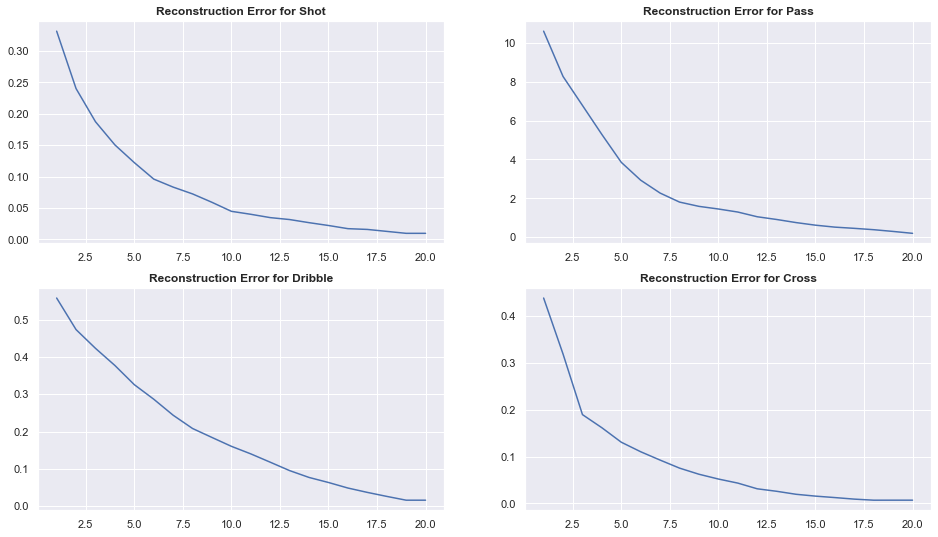

In [ ]:
nmf_rec_err = [
    [NMF(n_components=n_comps, random_state=100).fit(nmf_mat).reconstruction_err_
    for n_comps in range(1,21)]
    for nmf_mat in [nmf_shot_matrix, nmf_pass_matrix, nmf_dribble_matrix, nmf_cross_matrix]
]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,9))
for i, rec_err, action in zip(range(4), nmf_rec_err, ['Shot', 'Pass', 'Dribble', 'Cross']):
    axs[i//2,i%2].plot(range(1,21), rec_err)
    axs[i//2,i%2].set_title(f'Reconstruction Error for {action}', weight='bold')
plt.show()

Looking at the plots above, we see that it's hard to come by a profound elbow outside of the elbow plot for crosses. Still, for the other action types, we can pick a value that imitates an elbow and test its results below. Keep in mind, however, we would like for NMF to reduce the dimensionality of our dataset, so if two elbows are seen in any one of the plots above, I'll show preference for the value that provides lower dimensions.

After studying the plots, here are the selected number of components:

- Cross: 3
- Shot: 6
- Pass: 5
- Dribble: 5

Now for some intuition. We observe the most profound elbow for crosses, and this makes sense because crosses tend to happen within the attacking third of the pitch on either side of the goal. Shots also occur in the attacking third of the pitch, but - unlike crosses - they are much less frequent and occur closer to one another (whereas crosses occur on opposite sides of the pitch); hence, we'll require more components for describing shots. Unlike the previous two, dribbles and passes occur all over the pitch, with passes occurring far more often that dribbles.

In [ ]:
n_cross_components = 3
n_shot_components = 6
n_pass_components = 5
n_dribble_components = 5

##### **ii. Shot Data**

In [39]:
nmf_shot = NMF(n_components=n_shot_components, random_state=100)
nmf_shot_W = pd.DataFrame(nmf_shot.fit_transform(nmf_shot_matrix))
nmf_shot_H = pd.DataFrame(nmf_shot.components_, columns=nmf_shot_matrix.columns)
nmf_shot_clsmem = nmf_shot_W.apply(lambda x: x / sum(x), axis=1)

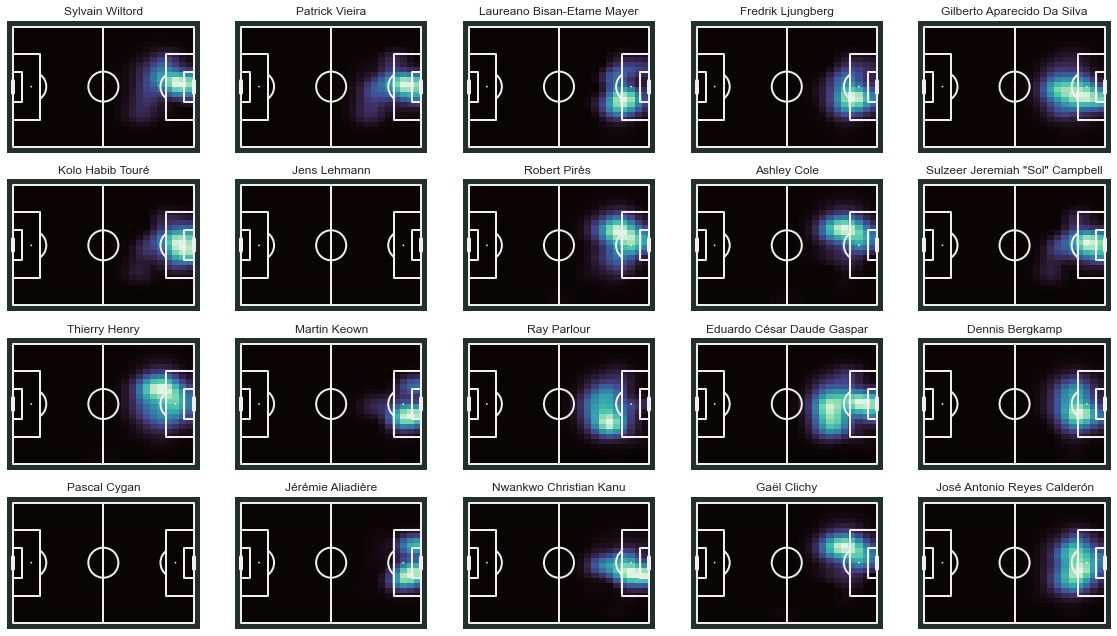

In [61]:
pitch = Pitch(pitch_type='statsbomb', line_zorder=2, pitch_color='#22312b', line_color='#efefef')
fig, ax = pitch.draw(nrows=4, ncols=5, figsize=(16,9))

for i, player in enumerate(nmf_shot_H.columns):
    statistic = np.dot(nmf_shot_W, nmf_shot_H[player].to_numpy()).reshape((24, 25))

    # construct stats object from binned data, bin mesh, and bin centers
    y, x = statistic.shape
    x_grid = np.linspace(0, 120, x + 1)
    y_grid = np.linspace(0, 80, y + 1)
    cx = x_grid[:-1] + 0.5 * (x_grid[1] - x_grid[0])
    cy = y_grid[:-1] + 0.5 * (y_grid[1] - y_grid[0])
    stats = dict(statistic=statistic, x_grid=x_grid, y_grid=y_grid, cx=cx, cy=cy)

    pcm = pitch.heatmap(stats, ax=ax[i//5, i%5], cmap='mako')
    ax[i//5, i%5].set_title(player.title())

##### **iii. Cross Data**

In [41]:
nmf_cross = NMF(n_components=n_cross_components, random_state=100)
nmf_cross_W = pd.DataFrame(nmf_cross.fit_transform(nmf_cross_matrix))
nmf_cross_H = pd.DataFrame(nmf_cross.components_, columns=nmf_cross_matrix.columns)
nmf_cross_clsmem = nmf_cross_W.apply(lambda x: x / sum(x), axis=1)

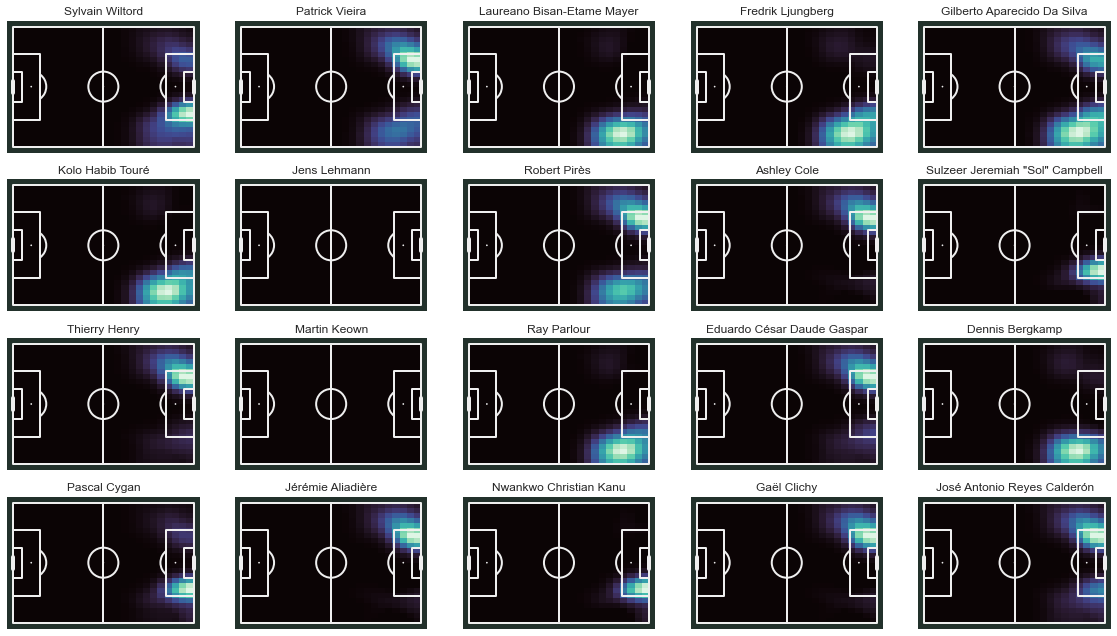

In [42]:
pitch = Pitch(pitch_type='statsbomb', line_zorder=2, pitch_color='#22312b', line_color='#efefef')
fig, ax = pitch.draw(nrows=4, ncols=5, figsize=(16,9))

for i, player in enumerate(nmf_cross_H.columns):
    statistic = np.dot(nmf_cross_W, nmf_cross_H[player].to_numpy()).reshape((24, 25))

    # construct stats object from binned data, bin mesh, and bin centers
    y, x = statistic.shape
    x_grid = np.linspace(0, 120, x + 1)
    y_grid = np.linspace(0, 80, y + 1)
    cx = x_grid[:-1] + 0.5 * (x_grid[1] - x_grid[0])
    cy = y_grid[:-1] + 0.5 * (y_grid[1] - y_grid[0])
    stats = dict(statistic=statistic, x_grid=x_grid, y_grid=y_grid, cx=cx, cy=cy)

    pcm = pitch.heatmap(stats, ax=ax[i//5, i%5], cmap='mako')
    ax[i//5, i%5].set_title(player.title())

##### **iv. Pass Data**

In [43]:
nmf_pass = NMF(n_components=n_pass_components, random_state=100)
nmf_pass_W = pd.DataFrame(nmf_pass.fit_transform(nmf_pass_matrix))
nmf_pass_H = pd.DataFrame(nmf_pass.components_, columns=nmf_pass_matrix.columns)
nmf_pass_clsmem = nmf_pass_W.apply(lambda x: x / sum(x), axis=1)

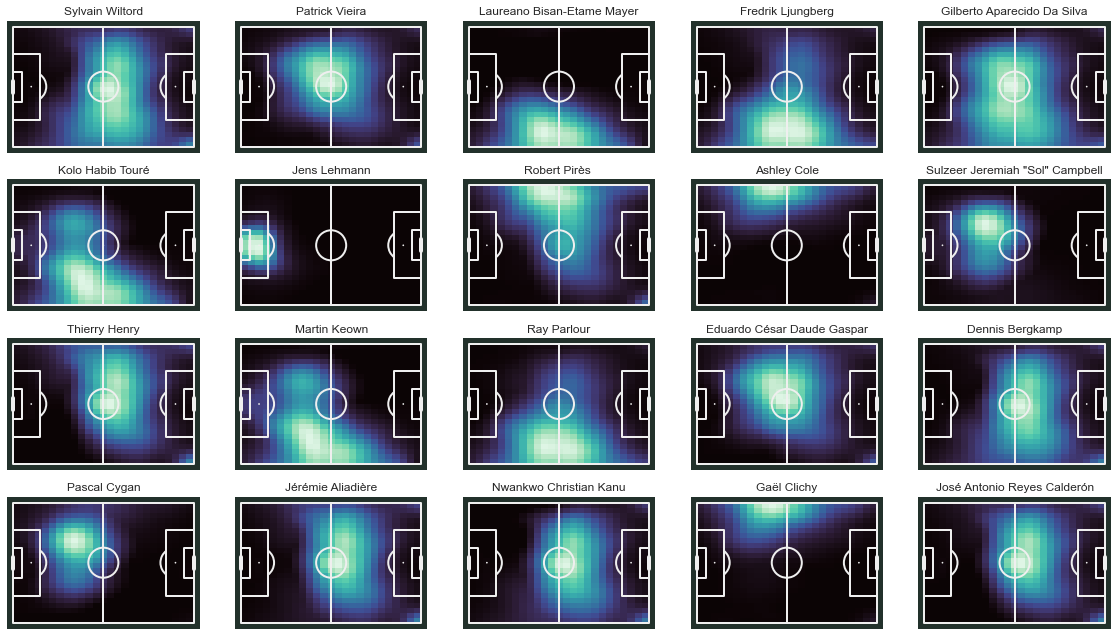

In [44]:
pitch = Pitch(pitch_type='statsbomb', line_zorder=2, pitch_color='#22312b', line_color='#efefef')
fig, ax = pitch.draw(nrows=4, ncols=5, figsize=(16,9))

for i, player in enumerate(nmf_pass_H.columns):
    statistic = np.dot(nmf_pass_W, nmf_pass_H[player].to_numpy()).reshape((24, 25))

    # construct stats object from binned data, bin mesh, and bin centers
    y, x = statistic.shape
    x_grid = np.linspace(0, 120, x + 1)
    y_grid = np.linspace(0, 80, y + 1)
    cx = x_grid[:-1] + 0.5 * (x_grid[1] - x_grid[0])
    cy = y_grid[:-1] + 0.5 * (y_grid[1] - y_grid[0])
    stats = dict(statistic=statistic, x_grid=x_grid, y_grid=y_grid, cx=cx, cy=cy)

    pcm = pitch.heatmap(stats, ax=ax[i//5, i%5], cmap='mako')
    ax[i//5, i%5].set_title(player.title())

##### **v. Dribble Data**

In [45]:
nmf_dribble = NMF(n_components=n_dribble_components, random_state=100)
nmf_dribble_W = pd.DataFrame(nmf_dribble.fit_transform(nmf_dribble_matrix))
nmf_dribble_H = pd.DataFrame(nmf_dribble.components_, columns=nmf_dribble_matrix.columns)
nmf_dribble_clsmem = nmf_dribble_W.apply(lambda x: x / sum(x), axis=1)

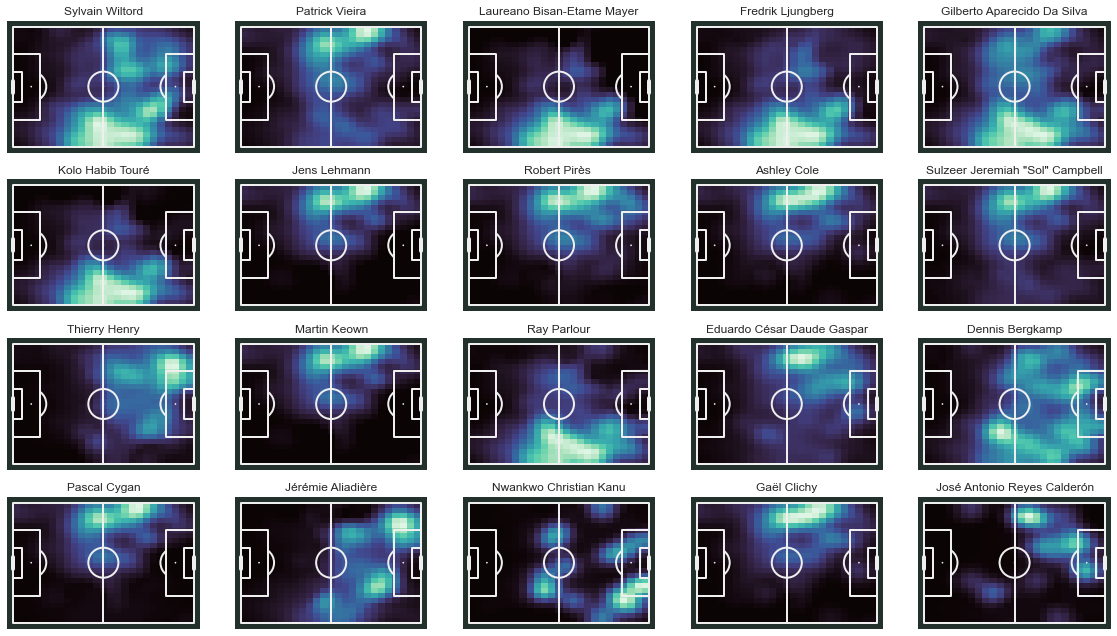

In [46]:
pitch = Pitch(pitch_type='statsbomb', line_zorder=2, pitch_color='#22312b', line_color='#efefef')
fig, ax = pitch.draw(nrows=4, ncols=5, figsize=(16,9))

for i, player in enumerate(nmf_dribble_H.columns):
    statistic = np.dot(nmf_dribble_W, nmf_dribble_H[player].to_numpy()).reshape((24, 25))

    # construct stats object from binned data, bin mesh, and bin centers
    y, x = statistic.shape
    x_grid = np.linspace(0, 120, x + 1)
    y_grid = np.linspace(0, 80, y + 1)
    cx = x_grid[:-1] + 0.5 * (x_grid[1] - x_grid[0])
    cy = y_grid[:-1] + 0.5 * (y_grid[1] - y_grid[0])
    stats = dict(statistic=statistic, x_grid=x_grid, y_grid=y_grid, cx=cx, cy=cy)

    pcm = pitch.heatmap(stats, ax=ax[i//5, i%5], cmap='mako')
    ax[i//5, i%5].set_title(player.title())

---

### **07. Evaluation**

---

Everything above looks pretty neat - each player has a heatmap for each of the four actions of interest. Now for the fun part - we can use these heatmaps to compare playing styles between players. Not only does this save us the frustration of listening to pundits who have no clue what they're talking about, but it also gives us joy knowing that statistics can be used for meaningful projects like such.

Let's first see what each of these components look like for each action type. These components represent one of the n clusters per action type. The more a player performs said action in said grid(s) of the pitch, the more weight is assigned to that action's cluster's membership score. The same is true for the contrary.

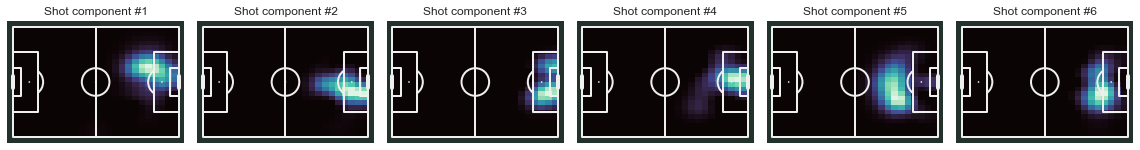

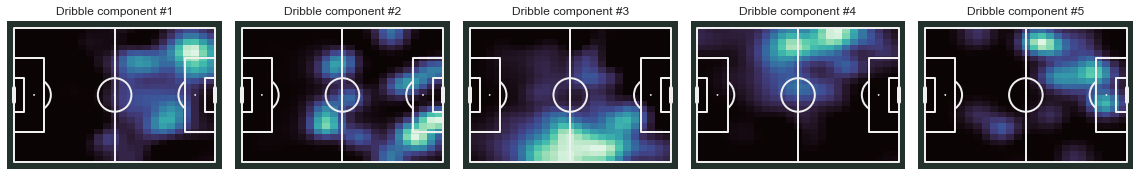

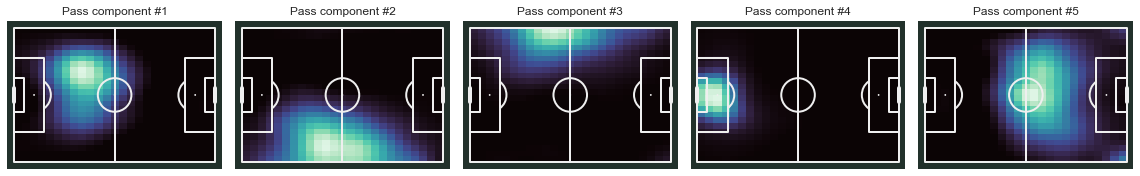

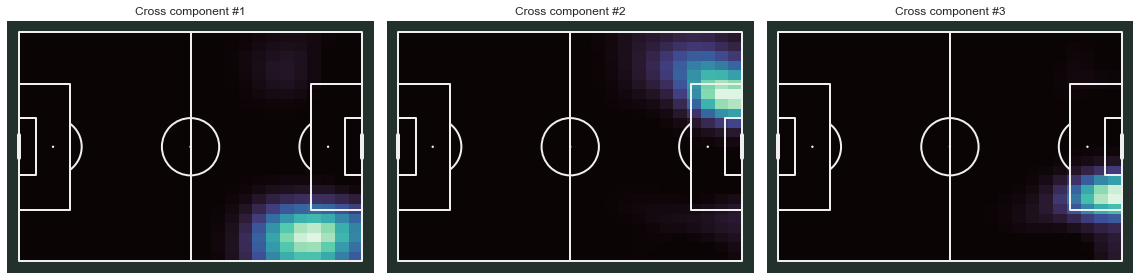

In [47]:
pitch = Pitch(pitch_type='statsbomb', line_zorder=2, pitch_color='#22312b', line_color='#efefef')

for action, nmf_W in zip(
    ['Shot', 'Dribble', 'Pass', 'Cross'],
    [nmf_shot_W, nmf_dribble_W, nmf_pass_W, nmf_cross_W]
    ):
    
    fig, ax = pitch.draw(ncols=nmf_W.shape[1], figsize=(16,9))
    
    for i in range(nmf_W.shape[1]):
        
        statistic = np.array(nmf_W.iloc[:, i]).reshape((24, 25))

        # construct stats object from binned data, bin mesh, and bin centers
        y, x = statistic.shape
        x_grid = np.linspace(0, 120, x + 1)
        y_grid = np.linspace(0, 80, y + 1)
        cx = x_grid[:-1] + 0.5 * (x_grid[1] - x_grid[0])
        cy = y_grid[:-1] + 0.5 * (y_grid[1] - y_grid[0])
        stats = dict(statistic=statistic, x_grid=x_grid, y_grid=y_grid, cx=cx, cy=cy)

        pcm = pitch.heatmap(stats, ax=ax[i], cmap='mako')
        ax[i].set_title(f'{action} component #{i+1}')
    
    plt.show()

We see that the components per action type tell their own story (as we promised way way above if you want to scroll that far) which opens up for an abundance of decisions that we now have proper information prior to consideration. However, since I'm not managing a club, we won't be taking these too seriously. Regardless, here's what we notice:

For shots:
- Component #1 -> edge of the eighteen-yard box, left side
- Component #2 -> edge of the six-yard box, right side
- Component #3 -> goal posts, either side
- Component #4 -> front of the goal
- Component #5 -> outside of the eighteen-yard box
- Component #6 -> edge of the eighteen-yard box, right side

For dribbles:
- Component #1 -> central to left corner of eighteen-yard box
- Component #2 -> (possibly) counterattacks leading into right corner of eighteen-yard box
- Component #3 -> down the right sideline
- Component #4 -> down the left sideline
- Component #5 -> (possibly) counterattacks leading into left corner of eighteen-yard box

For passes:
- Component #1 -> left central defender area (building up play)
- Component #2 -> right sideline (advancing ball forward)
- Component #3 -> left sideline (advancing ball forward)
- Component #4 -> goalkeeper region (playing out from the back)
- Component #5 -> central attacking third (holding possession, creating space)

For crosses:
- Component #1 -> right sideline of attacking third (wide cross from wingback)
- Component #2 -> left side of six-yard box (low cross in towards center of box)
- Component #3 -> right side of six-yard box (low cross in towards center of box)

Although for another study, it would be interesting to observe the end location of these actions. While we did consider the end location for some actions (passes, crosses) in our t-SNE algorithms, we only considered start locations since we care where a player tends to receive the ball.

Finally, we can map each of the player's "component scores" - their values from the `H` matrix - per action type and create a profile of "component preferences." Not only will this provide us with a distribution of what actions and where on the pitch a player tends to perform, but it also provides us with the opportunity to compare players' distributions and make inferences accordingly. For example, ..........

In [48]:
nmf_player_dict = {
    player: nmf_shot_H[player].append(nmf_dribble_H[player].append(nmf_pass_H[player].append(nmf_cross_H[player]))).reset_index(drop=True)
    for player in player_dict.keys()
}

In [49]:
total_components = sum([n_shot_components, n_dribble_components, n_pass_components, n_cross_components])
nmf_component_dict = {}
for component in range(total_components):
    nmf_component_dict[f'{component + 1}'] = []
    for player in nmf_player_dict:
        nmf_component_dict[f'{component + 1}'].append(nmf_player_dict[player][component])

In [50]:
X = pd.DataFrame(nmf_component_dict)
mod_X = pd.melt(X, value_vars=X.columns, var_name='component')
mod_X['player'] = [player for player in player_dict.keys()] * total_components

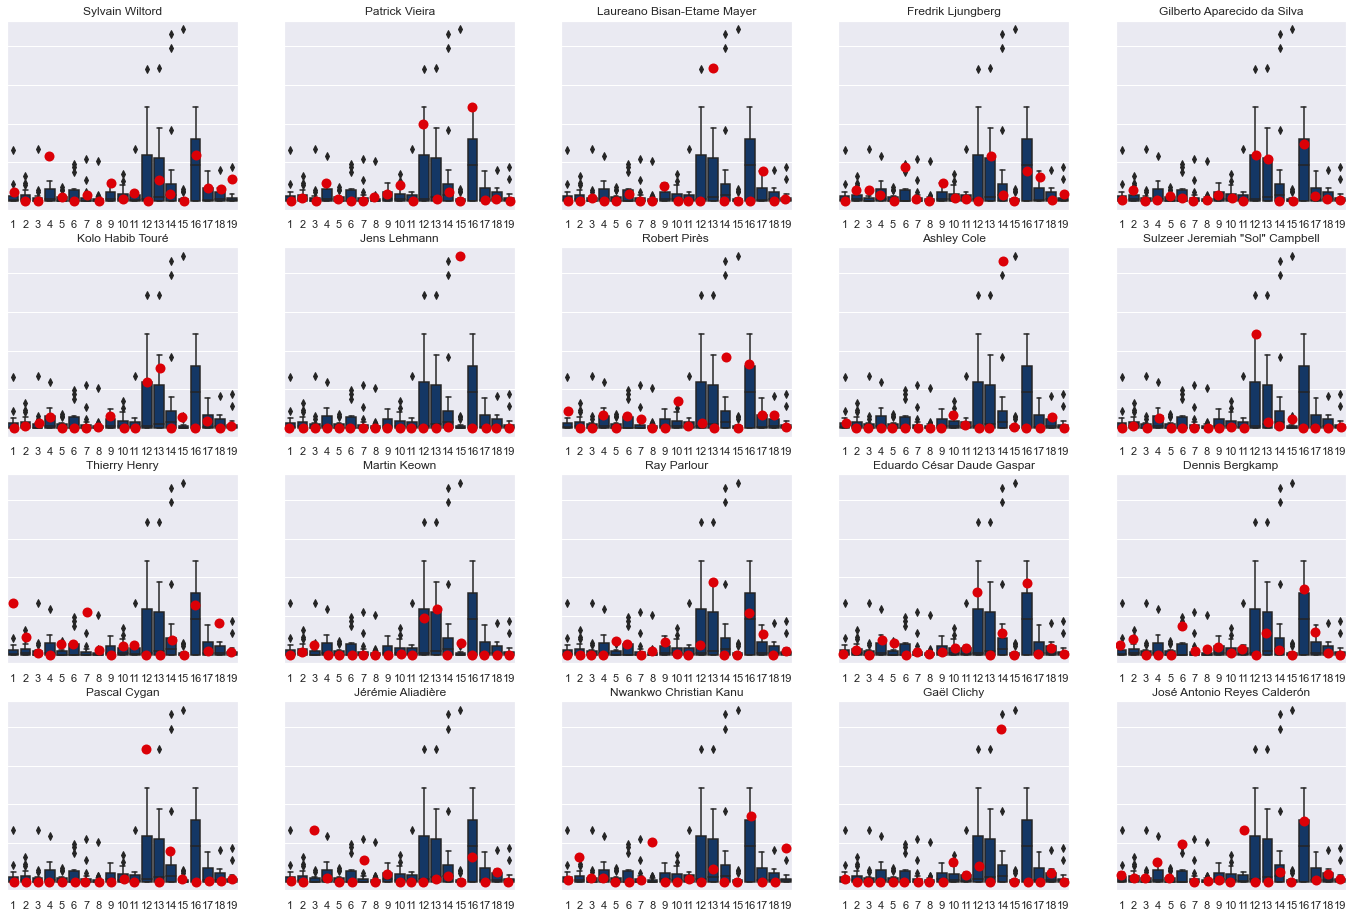

In [51]:
f, axs = plt.subplots(nrows=4, ncols=5, figsize=(24,16))
plt.title('Component Distribution per Player')

for i, player in enumerate(player_dict.keys()):
    # sns.set(rc={'figure.figsize':(9,6)})
    sns.boxplot(x='component', y='value', color='#063672', data=mod_X, ax=axs[i//5, i%5])
    sns.stripplot(x='component', y='value', color='#db0007', size=10, data=mod_X[mod_X['player'] == player], ax=axs[i//5, i%5])
    axs[i//5, i%5].set_title(f'{player}')
    axs[i//5, i%5].set_xlabel('')
    axs[i//5, i%5].set_ylabel('')
    axs[i//5, i%5].set_yticklabels([])

plt.show()

---
#### **08. Conculsion**
---

This project detailed how we can convert event-stream data into discrete, meaningful playing styles vectors for a given player. By first assessing clustering structure and discussing the strengths/drawbacks of our approaches, we proceeded to apply NMF to simultaneously cluster the grids on the pitch as well as the players in our dataset to define a player's playing style vector. These playing style vectors can be used to evaluate a player's performance over said time range and compare the playing styles of other players, a comparison that can, for example, inform decision makers in their creation of squad lineups and refine their approach in the transfer market.

Although the intentions of this project were maintained throughout, that does not imply it is a complete analysis. Future work could look into the problems we faced in when clustering the pass data, including looking at pass networks [2] to understand connectedness between actions that goes beyond simply where they occur on the pitch. Additionally, our matrix concatenation at the end is not a standardized approach and could be misleading; for example, attacking players like Thierry Henry show much higher preference than others when it comes to shooting, but among his other components, one could instead reason that he is also a passer in the opponent's box. While not entirely wrong, Henry should be known for his shooting before his passing, but the skewed frequency of passes misconstrues this playing style.

However, given the imperfections, it is a still a meaningful analysis that - as shown above - decision makers can use to make more informed decisions. While not all conclusions made in this project are absent of subjectivity, statistical methods such as NMF allow us to create inferences among player clusters and pitch clusters that would not have been possible otherwise. Algorithms such as NMF are powerful in the sense that they provide a plethora of clustering and interpretability benefits that most other unsupervised learning algorithms are not able to offer.

---
#### **A. Works Cited**

> [1] Alberto Barbosa, Pedro Ribeiro and Inês Dutra. ECML/PKDD 2021 Workshop on Machine Learning and Data Mining for Sports Analytics (MLSA 2021). September 2021. https://dtai.cs.kuleuven.be/events/MLSA21/papers/MLSA21_paper_barbosa.pdf

> [2] Arsalan Sattari, Ulf Johansson, Erik Wilderoth, Jasmin Jakupovic and Peter Larsson-Green. ECML/PKDD 2021 Workshop on Machine Learning and Data Mining for Sports Analytics (MLSA 2021). September 2021. https://dtai.cs.kuleuven.be/events/MLSA21/papers/MLSA21_paper_sattari.pdf

> [3] Tom Decroos and Jesse Davis. Player Vectors: Characterizing Soccer Players’ Playing Style from Match Event Streams. KU Leuven, Department of Computer Science. 2019. https://ecmlpkdd2019.org/downloads/paper/701.pdf